# BIO-ENG456: Controlling behavior in animalsand robots
Group: 8\
Lorenzo GERMINI\
Mathias NURIS-SOUQUET\
Hila VARDI

Date: 25.05.2021

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA 
from scipy.signal import butter, filtfilt

#one can add this library on this link https://pypi.org/project/behavelet/
#or directly running "pip install behavelet" on Conda or Python
from behavelet import wavelet_transform

# K-MEAN
from sklearn.cluster import KMeans

# GMM clustering
from sklearn import mixture

#correlation
import seaborn as sns

# logistic regression and MLP
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from collections import Counter

# 1.  Loading the behavioural/neural data

In [ ]:
beh_data_dir = "data/COBAR_behaviour_incl_manual_corrected.pkl"
beh_df = pd.read_pickle(beh_data_dir)

In [ ]:
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)

# 2. Data Preprocessing

### A. Noise reduction

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Apply a butterworth (lowpass) filter on the data for denoising according to the parameters given.
    Parameters
    ----------
    data : DataFrame
         The data to which you want to apply the noise filter.
    cutoff : float
        Cutoff frequency for your butterworth filter.
    fs : float
        Sampling frequency.
    order : integer
        Order of the filter.
    Returns
    -------
    reduced : numpy matrix
        Numpy matrix with denoised data according to the parameters given.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

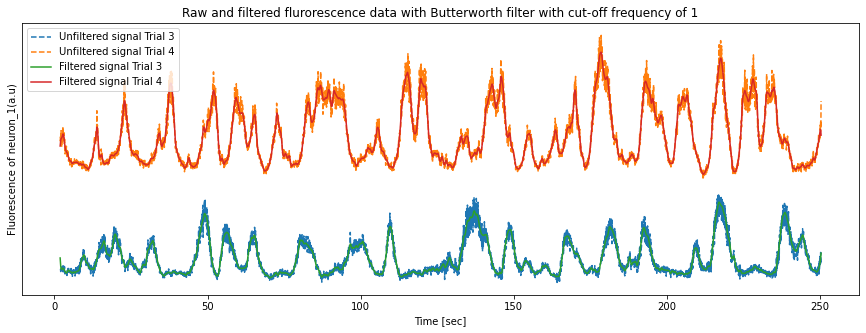

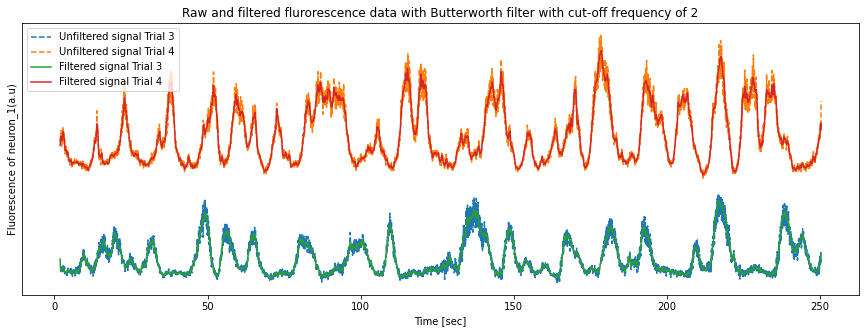

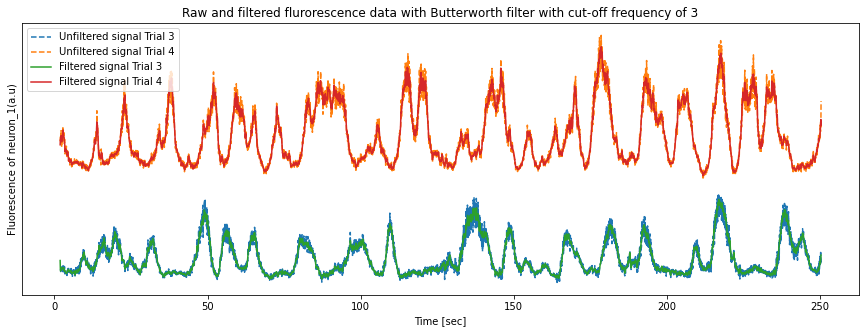

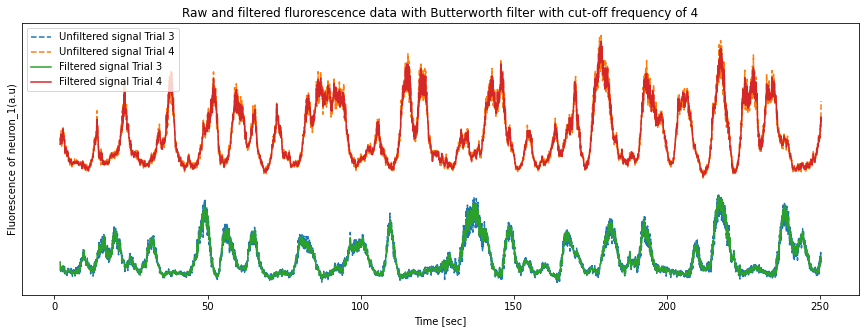

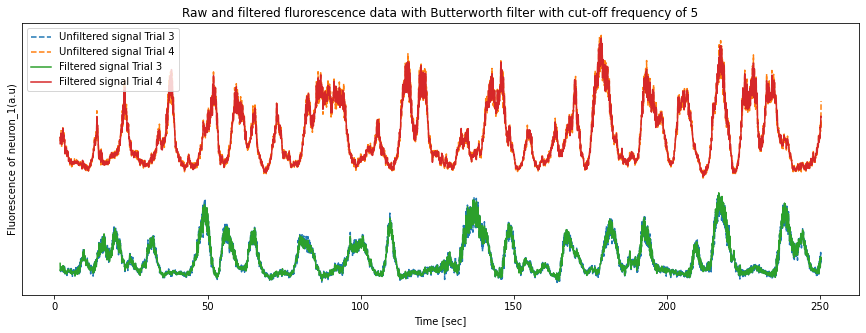

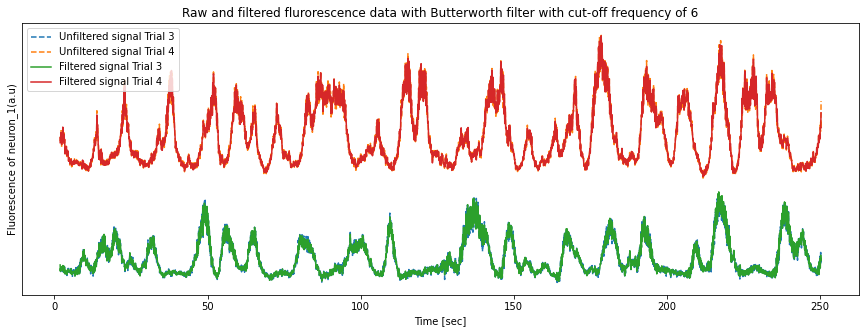

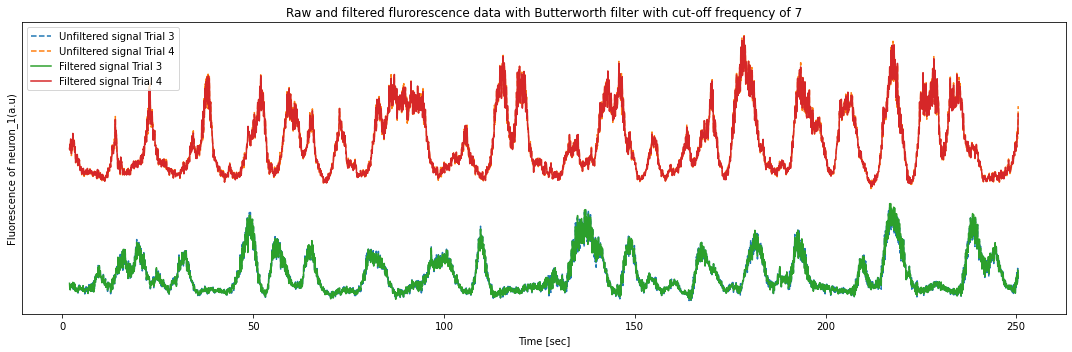

In [5]:
#plots to justify parameters choice for the filter for the neural data
filtered_neural_df = neural_df.copy(deep=True)
neural_signals_neuron_1 = neural_df["neuron_1"]
time = neural_df["t"]

#these parameters are fixed
fs=16.0
order=2

#optional interactive plot to enable the zooming in
#%matplotlib notebook
#import mpld3
#mpld3.enable_notebook()

#define range of cut-off frequencies to explore for the neural data
rangefcut=range(1,8,1)
ytick = []

time = neural_df["t"]
for cutoff in rangefcut:
    fig, ax = plt.subplots(figsize = (15,5))
    for i in range(3,5,1):
        # look at two trials at the same time for more robust results
        t=time[time.index.get_level_values("Trial")==i]
        neural_signals_neuron_1_trial_i = neural_signals_neuron_1[neural_df.index.get_level_values("Trial")==i]+i*1500
        plt.plot(t, neural_signals_neuron_1_trial_i, alpha = 1, linestyle='dashed', label=f'Unfiltered signal Trial {i}')
        ytick.append(neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
        plt.xlabel('Time [sec]')

    #superimpose filtered data
    filtered_neural_df_neuron_1 = butter_lowpass_filter(neural_df['neuron_1'], cutoff, fs, order) #this line has to be used with the following one
    filtered_neural_df.neuron_1=filtered_neural_df_neuron_1
    filtered_neural_signals_neuron_1 = filtered_neural_df['neuron_1']
    time=filtered_neural_df["t"]
    for i in range(3,5,1):
        filtered_neural_signals_neuron_1_trial_i = filtered_neural_signals_neuron_1[filtered_neural_df.index.get_level_values("Trial")==i]+i*1500
        t=time[time.index.get_level_values("Trial")==i]
        plt.plot(t, filtered_neural_signals_neuron_1_trial_i, alpha = 1, label=f'Filtered signal Trial {i}')
        ytick.append(filtered_neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
        plt.xlabel('Time [sec]')
        plt.title(f"Raw and filtered flurorescence data with Butterworth filter with cut-off frequency of {cutoff}")
        plt.legend(loc='upper left')
        plt.ylabel('Fluorescence of neuron_1(a.u)')
        
        plt.yticks([])
plt.tight_layout()
plt.show()
fig.savefig('report_images/rangebuttfilt_neuron_1.png')

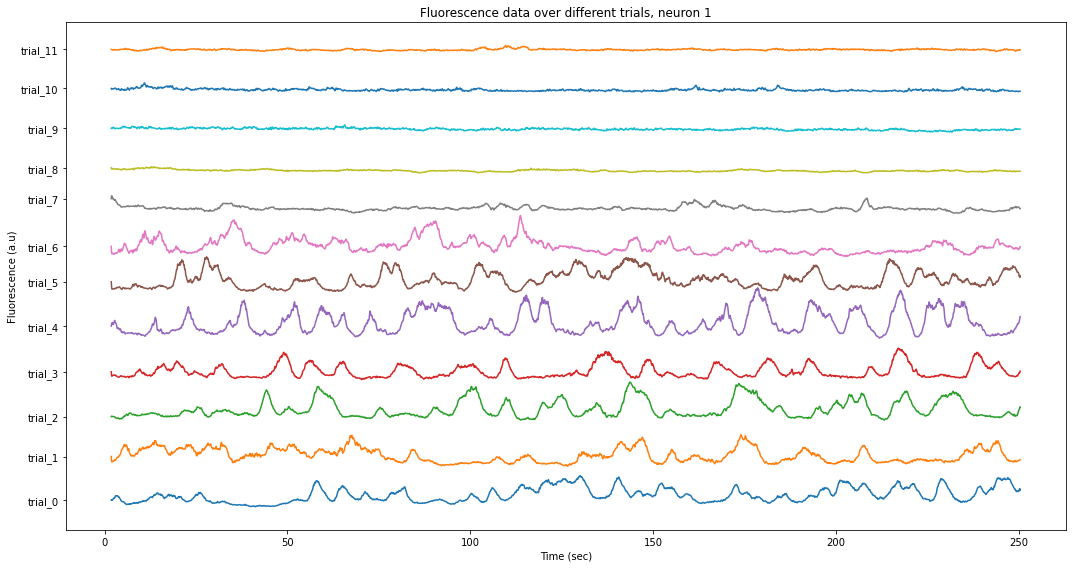

In [6]:
#plot filtered neural data for neuron_1 for all the trials for visual comparison with the raw plotting
filtered_neural_df = neural_df.copy(deep=True) 
fs=16.0
order=2
cutoff=2.5 #chosen value based on previous results

#apply filter for plotting
filtered_neural_df_neuron_1 = butter_lowpass_filter(neural_df['neuron_1'], cutoff, fs, order)
filtered_neural_df.neuron_1=filtered_neural_df_neuron_1
filtered_neural_signals_neuron_1 = filtered_neural_df['neuron_1']

# We construct a 3x3 matrix whose elements will be subplots depending on the column and row number they span
fig, ax1 = plt.subplots(figsize = (15,8))

ytick = []
for i in np.arange(12):   
    filtered_neural_signals_neuron_1_trial_i = filtered_neural_signals_neuron_1[neural_df.index.get_level_values("Trial")==i]
    #ax1.plot(neural_df["t"].iloc[:380], i*1500 + neural_signals_neuron_1_trial_i.iloc[:380], label = 'trial_' + str(i))
    ax1.plot(filtered_neural_df["t"].iloc[:4039], i*1500 + filtered_neural_signals_neuron_1_trial_i.iloc[:4039], label = 'trial_' + str(i))
    ytick.append(filtered_neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
    
ax1.set_ylabel('Fluorescence (a.u)')
ax1.set_xlabel('Time (sec)')
ax1.set_title('Fluorescence data over different trials, neuron 1')

ax1.set_yticks(np.array(ytick))
neuron_names = ['trial_' + str(i) for i in range(12)]
ax1.set_yticklabels(neuron_names)


plt.tight_layout()
plt.show()
fig.savefig('report_images/filtered_fluo_neurone1.png')

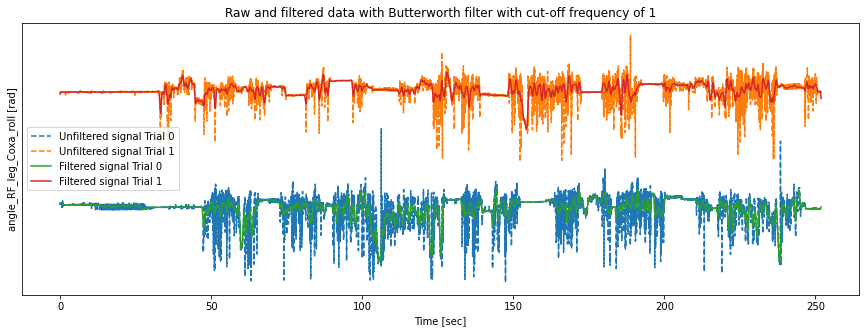

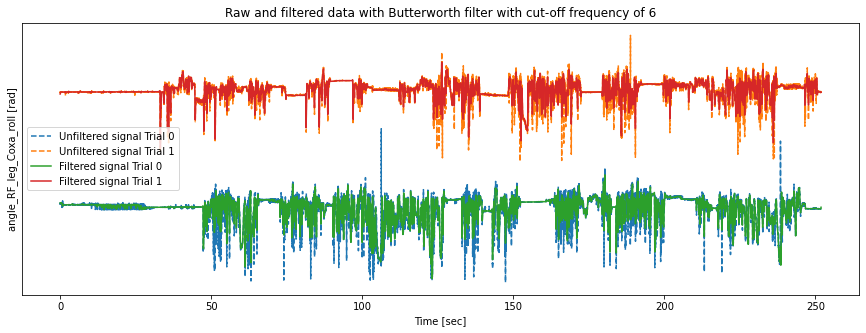

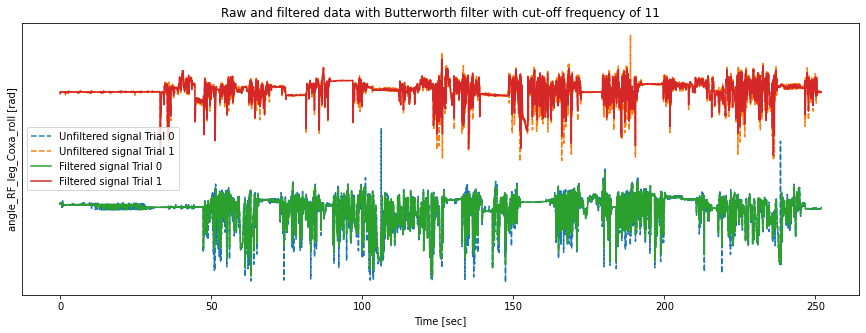

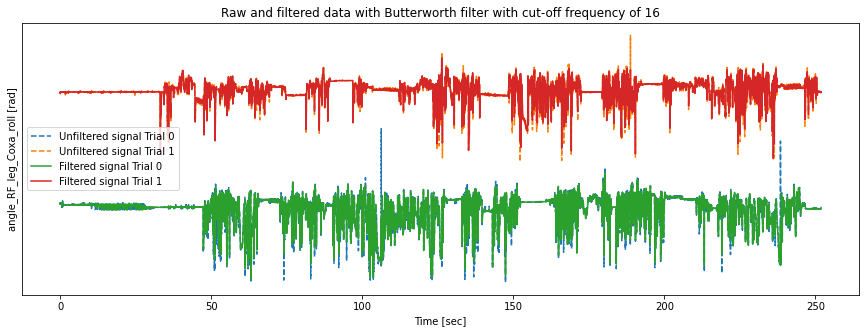

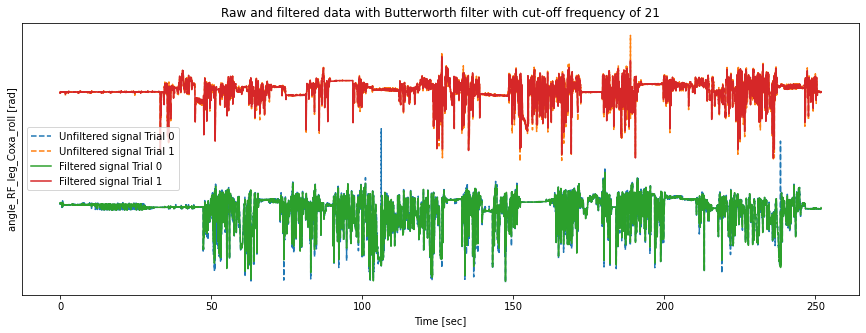

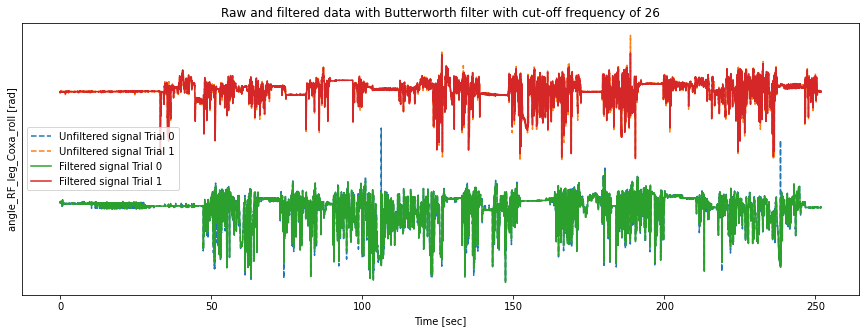

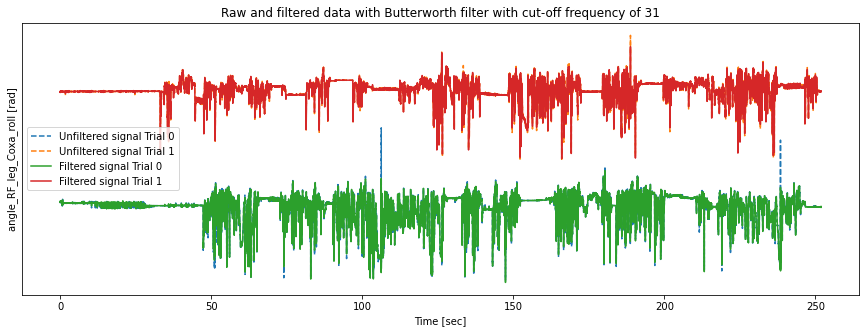

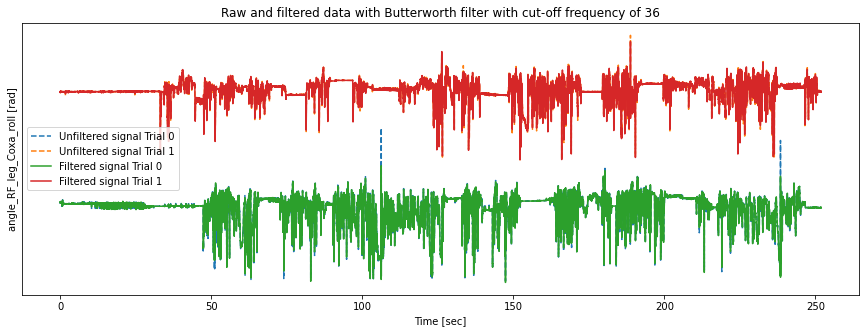

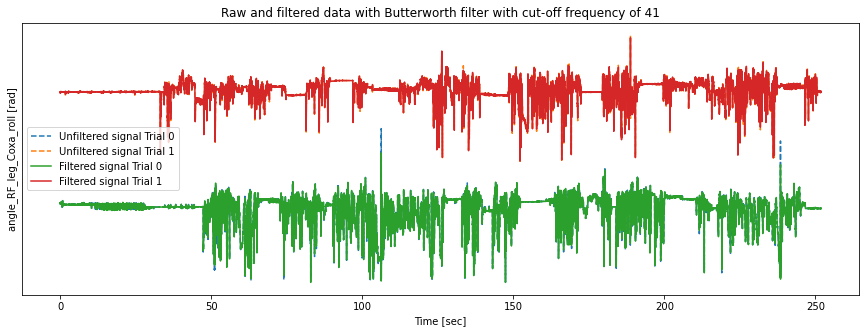

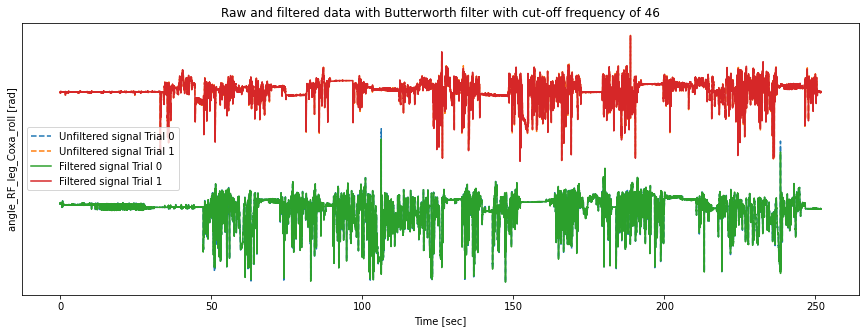

In [7]:
# plots to justify parameters choice for the filter for the behavioral data
filtered_beh_df = beh_df.copy(deep=True)

#these parameters are fixed
fs=100.0
order=2
#plot unifltered of one specific angle
angle_RF_leg_roll = beh_df["angle_RF_leg_Coxa_roll"]
time = beh_df["t"]

#interactive plot to enable the zooming in
#%matplotlib notebook
#import mpld3
#mpld3.enable_notebook()

#define range of cut-off frequencies to explore for the behavioral data
rangefcut=range(1,49,5)
for cutoff in rangefcut:
    fig, ax = plt.subplots(figsize = (15,5))
    for i in range(2):
        
        # look at two trials at the same time for more robust resultsfl
        y = angle_RF_leg_roll[angle_RF_leg_roll.index.get_level_values("Trial")==i]+3*i
        t=time[time.index.get_level_values("Trial")==i]
        plt.plot(t, y, alpha = 1, linestyle='dashed', label=f'Unfiltered signal Trial {i}')
        plt.xlabel('Time [sec]')
        plt.legend()
        
    #superimpose filtered data
    filtered_beh_df_anglerf = butter_lowpass_filter(beh_df["angle_RF_leg_Coxa_roll"], cutoff, fs, order)
    filtered_beh_df.angle_RF_leg_Coxa_roll=filtered_beh_df_anglerf
    filtered_angle_RF_leg_roll = filtered_beh_df["angle_RF_leg_Coxa_roll"]
    time = filtered_beh_df["t"]
    
    for i in range(2):
        y = filtered_angle_RF_leg_roll[filtered_angle_RF_leg_roll.index.get_level_values("Trial")==i]+3*i
        t=time[time.index.get_level_values("Trial")==i]
        plt.plot(t, y, alpha = 1, label=f'Filtered signal Trial {i}')
        plt.legend(loc='center left')
        plt.ylabel('angle_RF_leg_Coxa_roll [rad]')
        #plt.xlabel('Time [sec]')
        plt.title(f"Raw and filtered data with Butterworth filter with cut-off frequency of {cutoff}")
        plt.yticks([])
plt.show()
fig.savefig('report_images/rangebuttfilt_Coxa-roll.png')

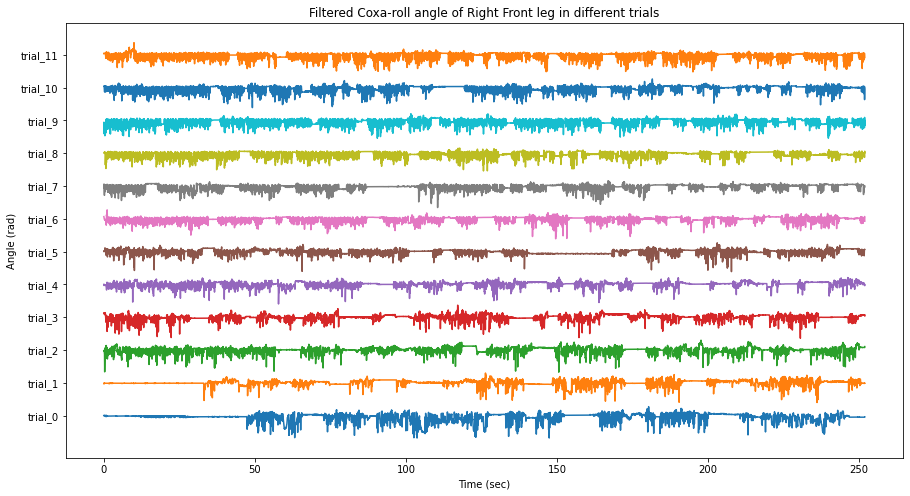

In [8]:
#plot  time traces of filtered angle_RF_leg_Coxa_roll across multiple trials to visually compare with plots of
#unfiltered data
filtered_beh_df = beh_df.copy(deep=True)
fs=100.0
order=2
cutoff=20 #chosen based on previous results


#plot unifltered of one specific angle
angle_RF_leg_roll = beh_df["angle_RF_leg_Coxa_roll"]
filtered_beh_df_anglerf = butter_lowpass_filter(beh_df["angle_RF_leg_Coxa_roll"], cutoff, fs, order)
filtered_beh_df.angle_RF_leg_Coxa_roll=filtered_beh_df_anglerf
filtered_angle_RF_leg_roll = filtered_beh_df["angle_RF_leg_Coxa_roll"]
time = filtered_beh_df["t"]

fig, ax = plt.subplots(figsize = (15,8))
ytick = []

for i in range(12):
    y = filtered_angle_RF_leg_roll[filtered_angle_RF_leg_roll.index.get_level_values("Trial")==i]+3*i
    t=time[time.index.get_level_values("Trial")==i]
    plt.plot(t, y, alpha = 1) 
    ytick.append(filtered_angle_RF_leg_roll.iloc[0] + i*3)

ax.set_yticks(np.array(ytick))
trial_names = ['trial_' + str(i) for i in range(12)]
ax.set_yticklabels(trial_names)
ax.set_ylabel('Angle (rad)')
ax.set_xlabel('Time (sec)')
ax.set_title('Filtered Coxa-roll angle of Right Front leg in different trials')
plt.show()
fig.savefig('report_images/w8_Coxa-roll.png')

In [9]:
#best parameters selected for filter for the behavioral data
fs=100.0
order=2
cutoff=20
filtered_beh_df = beh_df.copy(deep=True)#necessary to deep copy dataaframe
angl=beh_df.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
filtered_beh_df.iloc[:,2:44]=filtered_angl

##best parameters selected for filter for the neural data
filtered_neural_df = neural_df.copy(deep=True) 
fs=16.0
order=2
cutoff=2.5
neurons=neural_df.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
filtered_neural_df.iloc[:,1:124]=filtered_neurons


### B. Performing ΔF/F on neural data

In [10]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
# return baselined neural data
def neural_dF_F(data):
    rlt_Df_f=data.copy()
    nb_neurons = np.size(data,1)
    
    for j in np.arange(nb_neurons-1): 
        baseline = data['neuron_' + str(j)].rolling(window=3).mean()
        rlt_Df_f['neuron_' + str(j)] = (data['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())
    return rlt_Df_f

#final step of pre-processing : performing Delta_F/F on denoised signals
filtered_neural_df = neural_dF_F(filtered_neural_df)

In [11]:
# Global Parameters
nb_trials = 12
frames_in_trial = 4040

# behavior labels
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
# leg joint labels
joints = ['Coxa', 'Coxa_roll', 'Coxa_yaw', 'Femur', 'Femur_roll', 'Tibia', 'Tarsus']

# time vector
t = filtered_neural_df["t"]
time = t[t.index.get_level_values("Trial")==0]
time_offset = time.iloc[-1]
for i in range(nb_trials-1):
    time_trial_i = t[t.index.get_level_values("Trial")==(i+1)]
    time = pd.concat([time, time_trial_i+time_offset], axis=0)
    time_offset = time_offset + time_trial_i.iloc[-1]

### C. Downsampling manual labels

In [12]:
# these two functions are just wrappers around the numpy functions to apply them across dimension 0 only
def reduce_mean(values):
    return np.mean(values, axis=0)
def reduce_std(values):
    return np.std(values, axis=0)
def reduce_behaviour(values):
    """
    this is just a sketch for how to reduce behavioural classes. 
    It picks whatever behaviour occurs the most.
    The function handles the case when two behaviours are equally likely thanks to the chosen treshold,
    and assures, given that the values are always 6 or 7, that if 4/6 or 4/7 behaviour frames are not labelled the same way
    returns nan and the data is excluded.
    """
    unique_values, N_per_unique = np.unique(values, return_counts=True)
    i_max = np.argmax(N_per_unique)

    threshold = 4 #this treshold shows more robustness then using the 0.75
    for idx, unique_value in enumerate(unique_values):
        if N_per_unique[idx] > threshold:
            return unique_value
    return "nan"

def reduce_during_2p_frame(twop_index, values, function=reduce_mean):
    """
    Reduces all values occuring during the acquisition of a
    two-photon imaging frame to a single value using the `function` given by the user.
    Parameters
    ----------
    twop_index : numpy array
        1d array holding frame indices of one trial.
    values : numpy array
        Values upsampled to the frequency of ThorSync,
        i.e. 1D numpy array of the same length as
        `frame_counter` or 2D numpy array of the same length.
    function : function
        Function used to reduce the value,
        e.g. np.mean for 1D variables
    Returns
    -------
    reduced : numpy array
        Numpy array with value for each two-photon imaging frame.
    """
    
    if len(twop_index) != len(values):
        raise ValueError("twop_index and values need to have the same length.")
    if len(values.shape) == 1:
        values = np.expand_dims(values, axis=1)
        squeeze = True
    else:
        squeeze = False
    N_samples, N_variables = values.shape
    
    index_unique = np.unique(twop_index)
    index_unique = np.delete(index_unique, index_unique==-9223372036854775808)
    
    dtype = values.dtype
    if np.issubdtype(dtype, np.number):
        dtype = np.float
    else:
        dtype = np.object
    reduced = np.empty((len(index_unique), N_variables), dtype=dtype)

    for i, index in enumerate(index_unique):
        reduced[i] = function(values[twop_index==index, :])

    return np.squeeze(reduced) if squeeze else reduced

# 3. Investigating clustering of neurons' activity: find neurons that correlate with each other

This section aims at finding neurons that activate at similar times. This is done by doing a Principal Component Analysis (PCA) followed by unsupervised clustering. The clustering is then evaluated using inter-neuron correlation.

### A. PCA 

In [13]:
# Functions required for PCA 

# standardize the data
def standardize(data):
    Feature_scaler = sklearn.preprocessing.StandardScaler().fit(data)
    return sklearn.preprocessing.scale(data)

# apply PCA:  
# input samples: neurons
# input features: time samples
def PCA_temporal(data_norm, time, plot=False):

    pca = PCA(n_components=27)
    data_new = pca.fit_transform(data_norm.T)
    print('Variance explained by first 27 pricipal components:')
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    
    if plot:
        #plot loadings
        fig, ax = plt.subplots()
        loadings = pd.DataFrame(pca.components_[0:2].T, columns=['PC1', 'PC2'])
        plt.plot(time, loadings['PC1'], label = 'PC1', alpha=0.5)
        plt.plot(time, loadings['PC2'], label = 'PC2', alpha=0.5)
        plt.title('PCA Loadings of Neural Activity')
        plt.xlabel('Time point [s]')
        plt.ylabel('PCA weight')
        plt.legend()
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_loadings.png')
        
        fig, ax = plt.subplots()
        #scatter plot of first two components
        plt.scatter(data_new[:,0], data_new[:,1], alpha = 0.5) 
        plt.title('PCA Projected Neurons')
        plt.xlabel('PCA component 1 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
        plt.ylabel('PCA component 2 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_scatter.png')
        
    return data_new, pca

Variance explained by first 27 pricipal components:
[0.27332419 0.26424122 0.06765547 0.03619374 0.0326937  0.0254746
 0.02292318 0.01734588 0.01707517 0.01548904 0.01295125 0.01225216
 0.01175102 0.01067083 0.00938809 0.0088493  0.00829756 0.00770566
 0.00727813 0.00614843 0.00559473 0.00521723 0.00487307 0.00450777
 0.0043948  0.00417667 0.00376845]
0.9002413457545486


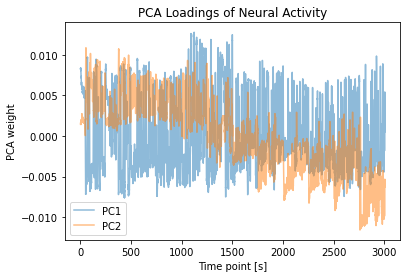

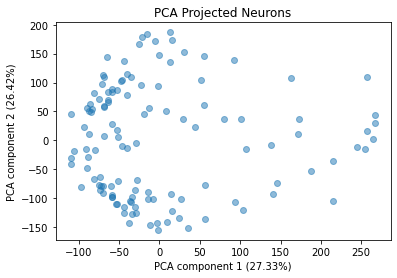

In [14]:
# PCA implementation (all trials are used as data)
X = filtered_neural_df.filter(regex="neuron")

X_norm = standardize(X)
X_new, pca = PCA_temporal(X_norm, time, plot=True)


### B. clustering
After the dimension reduction done with the PCA, the neurons can be clustered. These clusters represent neurons that have similar signals.

In [15]:
# cluster data using kmeans
# returns the classes and class names
def kmeans_cluster(data, nb_clusters, plot=False):
    
    #fit kmeans
    kmeans = KMeans(n_clusters=nb_clusters, init='random', n_init=1, verbose=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of KMEANS clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('Feature 1')

        plt.ylabel('Feature 2')
        plt.title('KMEANS clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_kmeans.png')
    
    return labels, class_names

# cluster data using GMMs
# returns the classes and class names
def GMM_cluster(data, nb_components, plot=False):
    
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=nb_components, covariance_type='full').fit(data)
    
    labels = gmm.predict(data)
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of GMM clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('Feature 1')

        plt.ylabel('Feature 2')
        plt.title('GMM clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_GMM.png')
        
    return labels, class_names

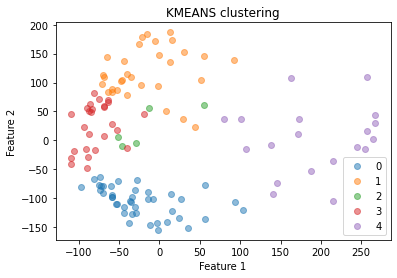

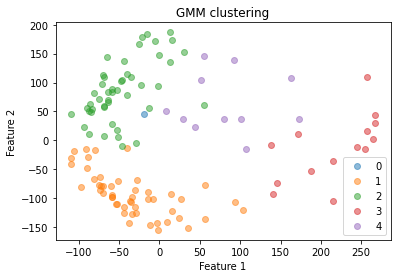

In [16]:
kmeans_labels, kmeans_names = kmeans_cluster(X_new, nb_clusters=5, plot=True)
GMM_labels, GMM_names = GMM_cluster(X_new, nb_components=5, plot=True)

### C. Neural activity of neurons from the same and different clusters

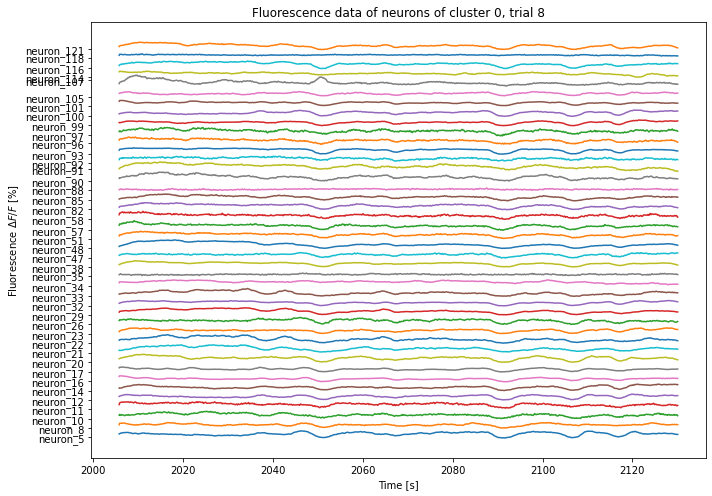

In [17]:
# compare neuronal activity of neurons of the same cluster: trial 8 (first half)
trial = 8
frame_i = int(frames_in_trial*(trial))
frame_f = int(frames_in_trial*(trial+0.5))

fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neurons_cluster = np.where(kmeans_labels == kmeans_names[0])[0]
for i,neuro_id in enumerate(neurons_cluster): 
    neural_signals_neuron_i = X_norm[:,neuro_id]
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'neuron_' + str(neuro_id))
    
    #frames_in_trial
    ytick.append(i*5 + neural_signals_neuron_i[0])
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time [s]')
plt.title('Fluorescence data of neurons of cluster 0, trial 8')

plt.yticks(np.array(ytick))
neuron_names = ['neuron_' + str(i) for i in neurons_cluster]
ax.set_yticklabels(neuron_names)

plt.tight_layout()
plt.show()
fig.savefig('report_images/cluster0_signal.png')


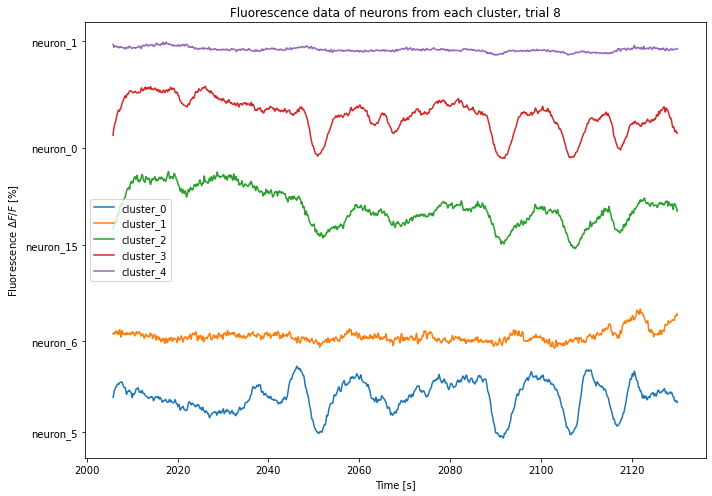

In [18]:
# compare neuronal activity of neurons of different clusters: trial 8
fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neuron_names = []
for i in range(len(kmeans_names)):
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    neural_signals_neuron_i = X_norm[:,neurons_cluster[0]]
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'cluster_' + str(i))
    
    ytick.append(i*5 + neural_signals_neuron_i[0])
    neuron_names.append('neuron_' + str(neurons_cluster[0]))
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time [s]')
plt.title('Fluorescence data of neurons from each cluster, trial 8')

ax.set_yticks(np.array(ytick))
ax.set_yticklabels(neuron_names)
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('report_images/clusters_diff_signal.png')

### D. Inter-neuron correlation
To evaluate the similarity between the signals of neurons from the same cluster, we can find their correlation coefficients.

In [19]:
# plot correlation coefficient of given data
def plot_correlation_coeff(data, title, filename):
    #Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (15,10))

    #Compute the correlation matrix
    correlation = data

    corr = correlation.corr()

    #Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    #Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.xlabel('neuron id')
    plt.ylabel('neuron id')
    plt.title(title)
    plt.show()
    fig.savefig('report_images/'+filename+'.png')

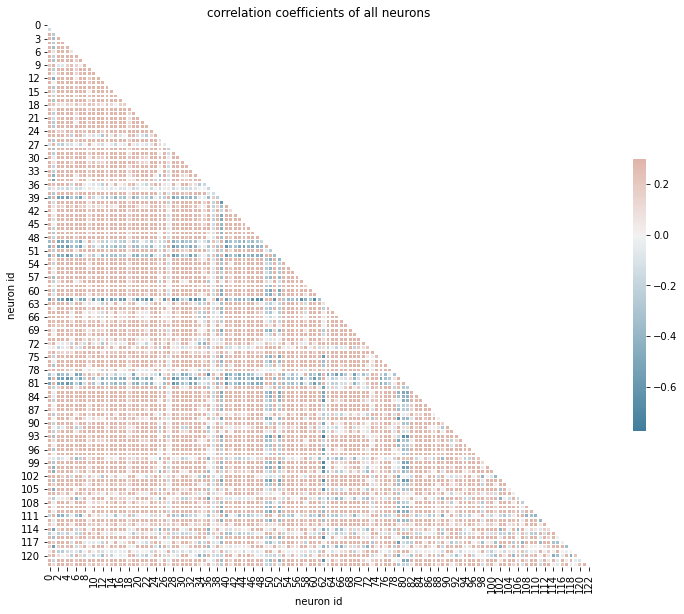

In [20]:
# correlation coefficient of all the neurons
plot_correlation_coeff(pd.DataFrame(data=X_norm), title='correlation coefficients of all neurons', filename='corr_all_neurons')

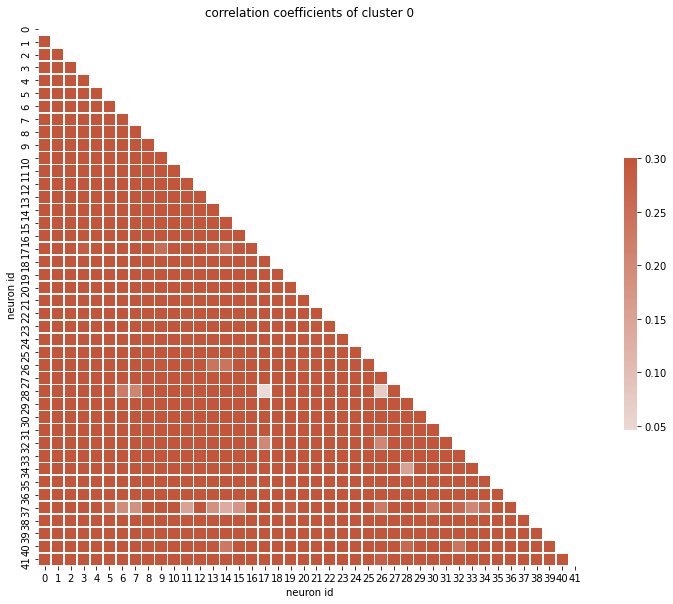

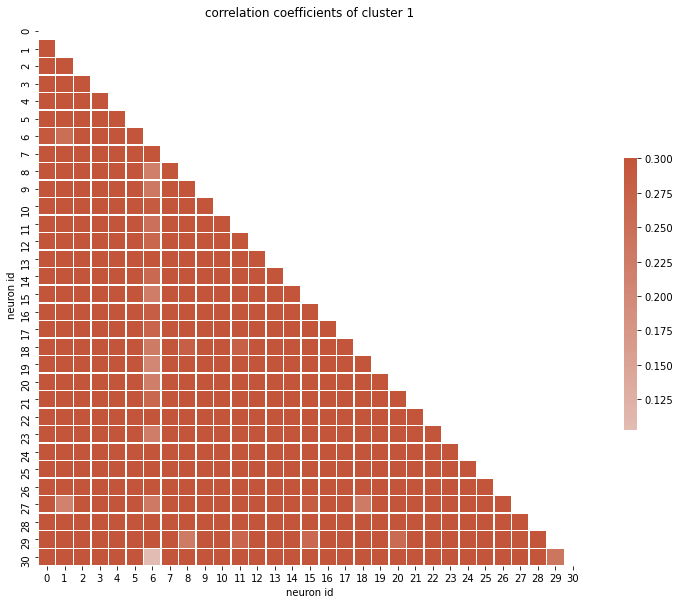

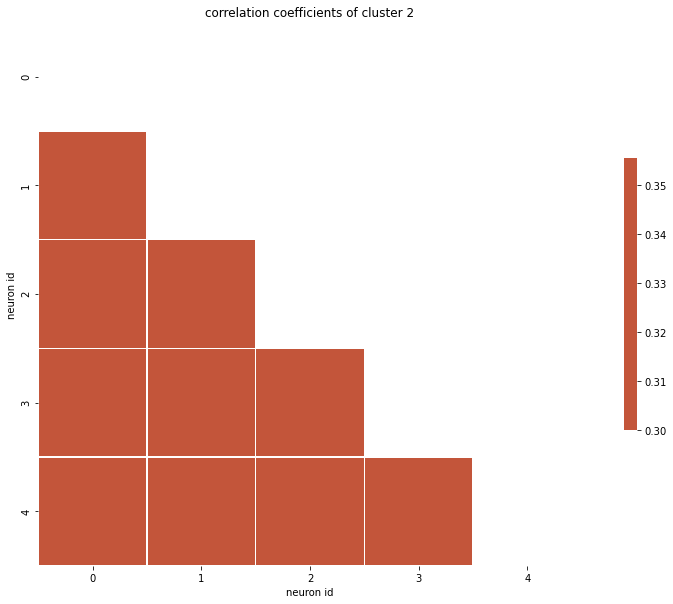

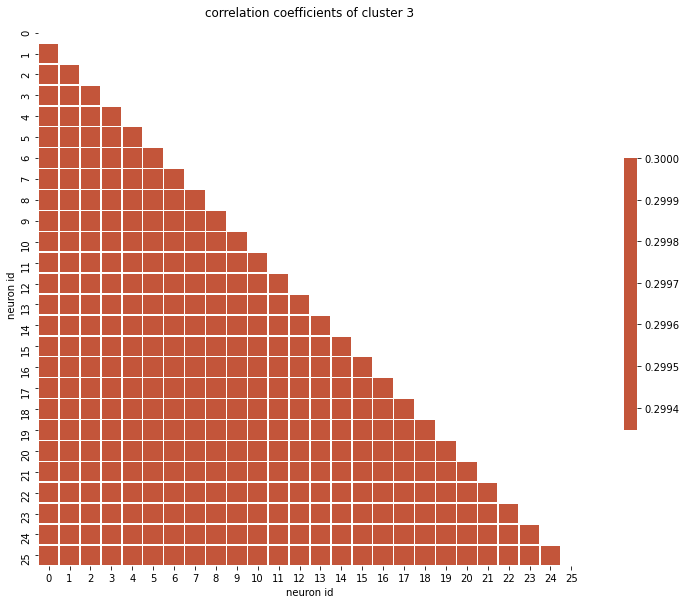

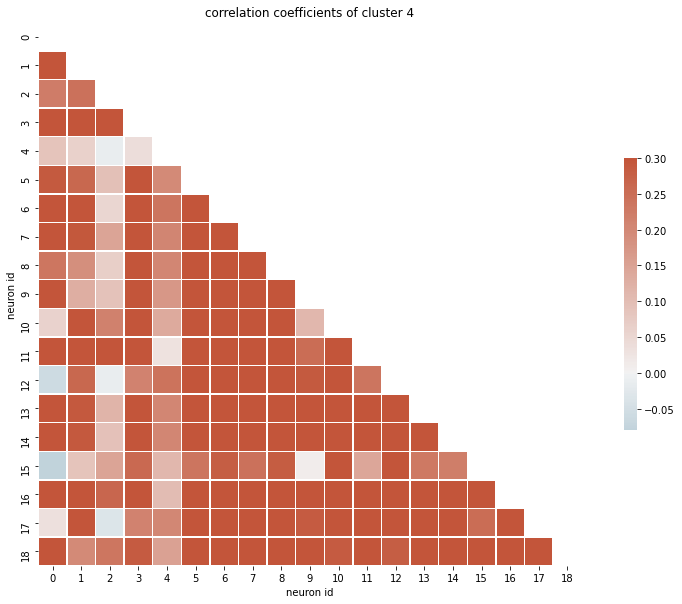

In [21]:

for i in range(len(kmeans_names)):  
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                          filename='corr_kmeans{}'.format(i))

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)


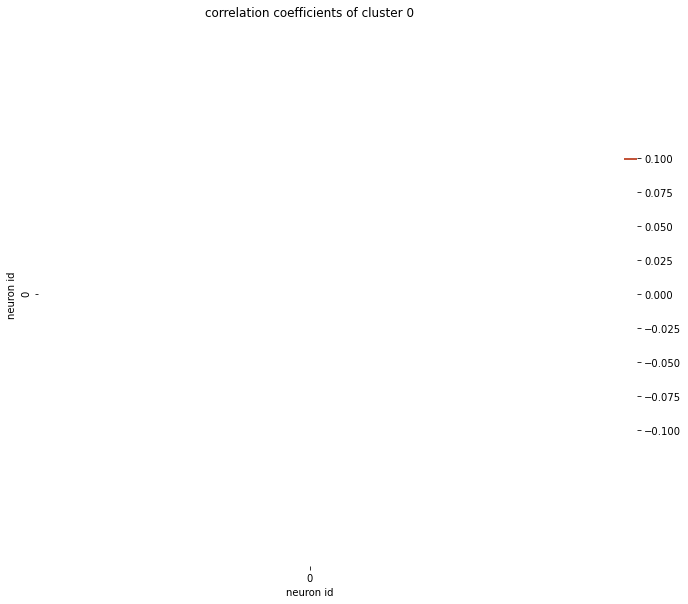

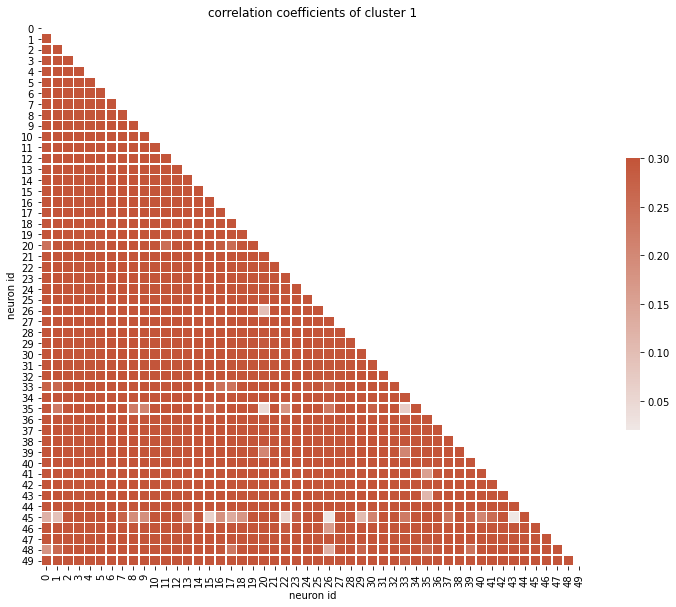

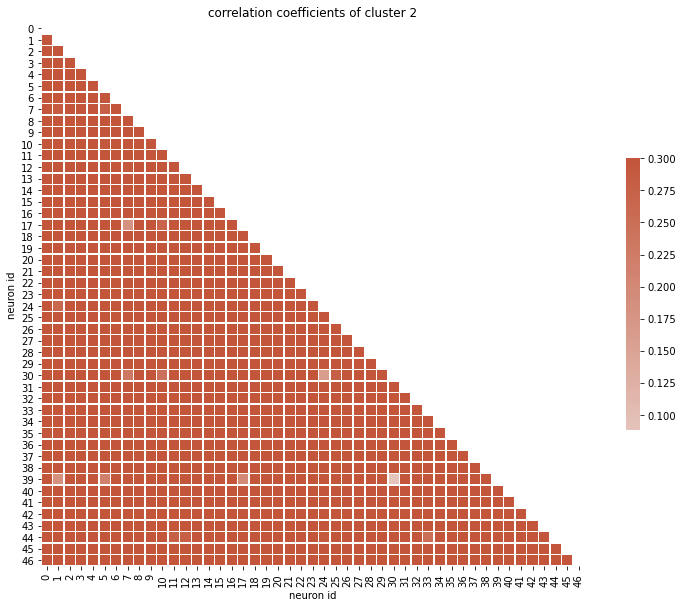

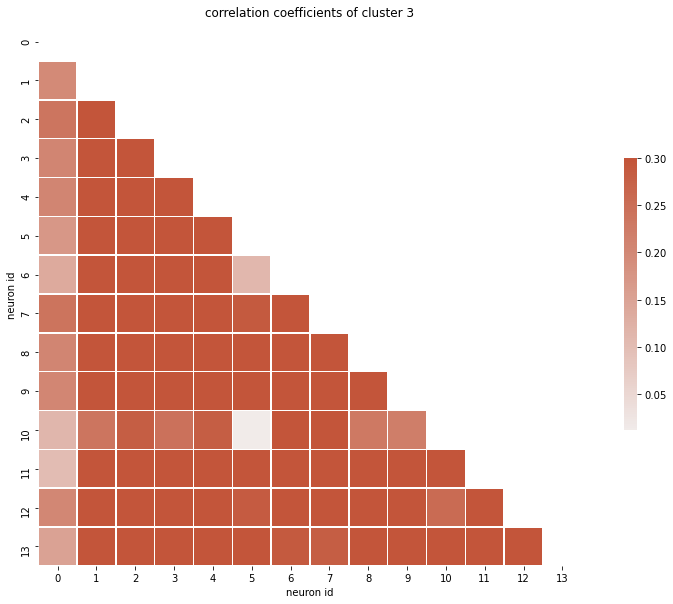

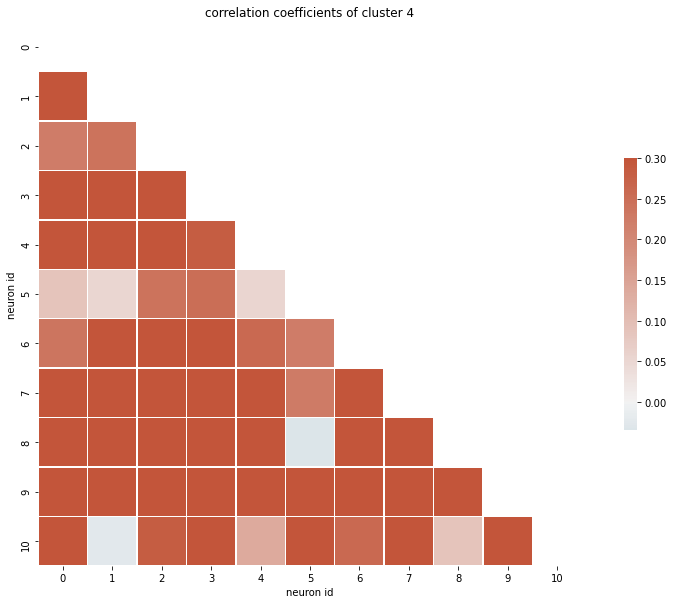

In [22]:
for i in range(len(GMM_names)):  
    neurons_cluster = np.where(GMM_labels == GMM_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                           filename='corr_gmm{}'.format(i))

# 4. Neural Data Correlations


### A. Correlation between neural activity and behaviour

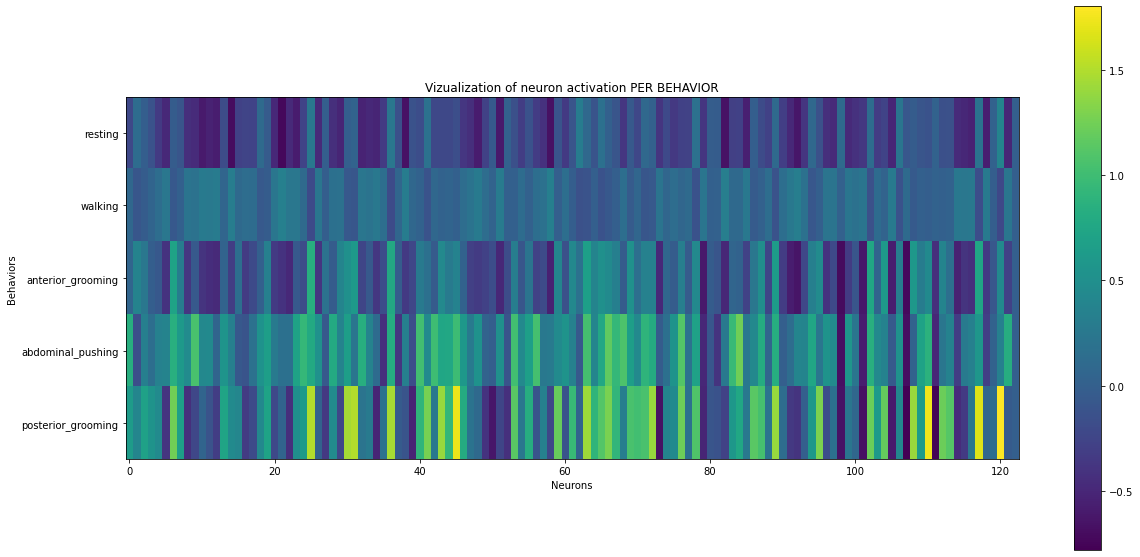

In [23]:
#step1 : standardization
std_Df_f = filtered_neural_df.copy()
for j in np.arange(123): 
    baseline = filtered_neural_df['neuron_' + str(j)].mean()
    std_Df_f['neuron_' + str(j)] = (filtered_neural_df['neuron_' + str(j)]-filtered_neural_df['neuron_' + str(j)].mean())/(filtered_neural_df['neuron_' + str(j)].std())

#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
std_Df_f['Manual'] = filtered_beh_df['Manual']
ytick=[0,1,2,3,4]
val = np.zeros((5,123))

for i in range (len(behaviors)):
    b = behaviors[i]
    behavior_data = std_Df_f[std_Df_f['Manual']==b]
    behavior_data
    for j in range (122):
        val[i,j]=behavior_data['neuron_' + str(j)].mean()

fig, ax2 = plt.subplots(figsize = (20,10))
ax2.set_yticks(ytick)
ax2.set_yticklabels(behaviors)
ax2.set_title('Vizualization of neuron activation PER BEHAVIOR')
ax2.set_ylabel('Behaviors')
ax2.set_xlabel('Neurons')
plt.imshow(val, aspect=10)
plt.colorbar()
plt.show()
fig.savefig('report_images/neuron_act_per_behavior.png')

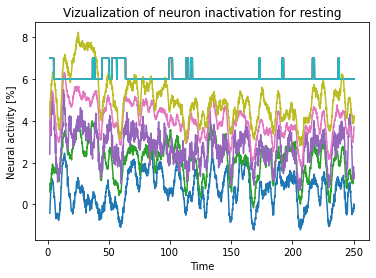

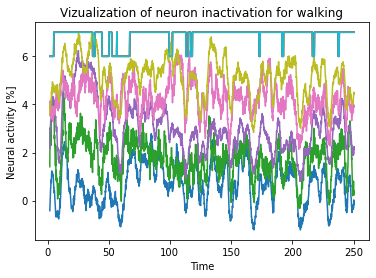

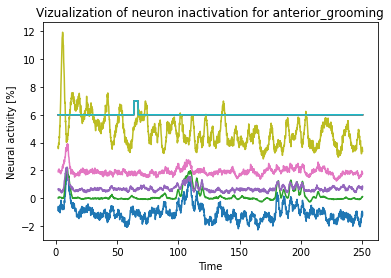

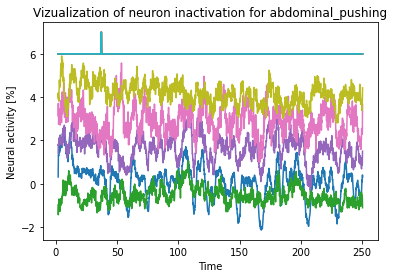

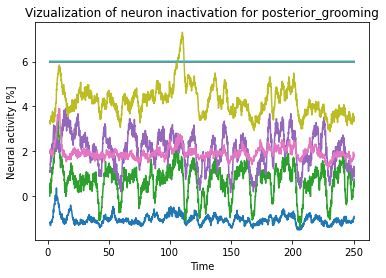

In [24]:
#getting more implicated neurons 
plots_act= val.copy()
nbr_required_neurons=5
neurons= np.zeros((5,nbr_required_neurons))

for i in range (len(behaviors)):
    for j in range (nbr_required_neurons):
        index_max=(np.int_((np.where(abs(plots_act[i])==abs(plots_act[i]).max()))))[0,0]
        neurons[i,j]=index_max
        plots_act[i,index_max]=0
        
neurons=np.int_(neurons)

#try for a specific trial, otherwise it's impossible to read it
try_trial = std_Df_f[std_Df_f.index.get_level_values("Trial")==11].copy(deep=True)
indexs_beh=[]

for i in range (len(neurons)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,4))
    
    for j in range (len(neurons[1])):
        plot_beh=np.zeros((len(try_trial['t'])))
        indexs_beh= np.where(try_trial['Manual']==behaviors[i])
        plot_beh[indexs_beh] = len(neurons[1])+2    
        indexs_= np.where(try_trial['Manual']!=behaviors[i])
        plot_beh[indexs_] = len(neurons[1])+1 
        plt.plot(try_trial['t'], j+(try_trial['neuron_'+str(neurons[i,j])]))
        plt.plot(try_trial['t'], plot_beh)
    name_ax.set_title('Vizualization of neuron inactivation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    #name_ax.legend('neuron_'+str(neurons[i,0]), 'neuron_'+str(neurons[i,1]))
    plt.show()
    name_fig.savefig('report_images/valuable_neuron_for_'+behaviors[i]+'.png')

### B. correlation between neural data and behavioral data

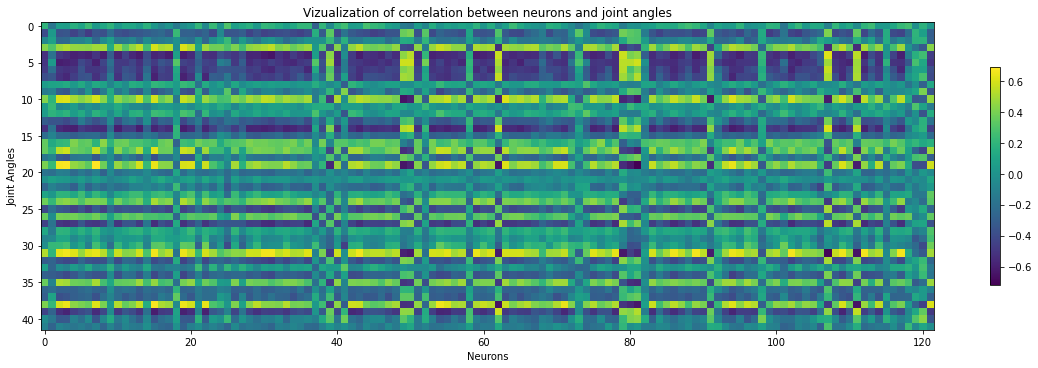

In [25]:
from scipy import stats
nbr_neurons = 122
nbr_beh_param = filtered_beh_df.filter(regex='angle').columns
correlation = np.zeros((len(nbr_beh_param),nbr_neurons))

for j in range (len(nbr_beh_param)): 
    twop_index = filtered_beh_df[filtered_beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
    values = filtered_beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[j]].to_numpy()
    angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
    for i in range (nbr_neurons) : 
        a=stats.spearmanr(std_Df_f['neuron_'+str(i)][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
        correlation[j,i]=a[0]
#plot
fig, ax2 = plt.subplots(figsize = (20,40))
ax2.set_title('Vizualization of correlation between neurons and joint angles')
ax2.set_ylabel('Joint Angles')
ax2.set_xlabel('Neurons')
plt.imshow(correlation)
plt.colorbar(shrink=0.1)
plt.show()
fig.savefig('report_images/correlation_btw_joint_angles_&_neuron.png')

In [26]:
first=pd.DataFrame(correlation)
first=first.drop(first.columns[[1,9,14,18,21,24,25,26,27,29,37,39,41,49,50,52,58,62,72,73,74,79,80,81,82,90,91,98,107,111,115,118,119,120]], axis=1)
first.to_numpy()
second=pd.DataFrame(correlation)
second=second[[1,9,14,18,21,24,25,26,27,29,37,39,41,49,50,52,58,62,72,73,74,79,80,81,82,90,91,98,107,111,115,118,119,120]]
second=second.drop(second.columns[[0,1,2,3,4,5,6,7,8,9,10,12,15,16,18,19,20,24,25,30,31,32,33]], axis=1)
second=second.to_numpy()

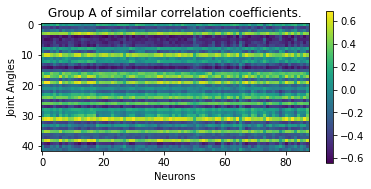

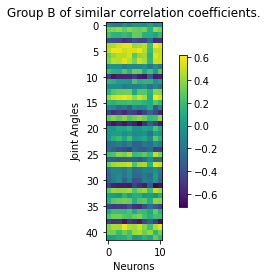

In [27]:
#plot group A
fig, ax2 = plt.subplots()
ax2.set_title('Group A of similar correlation coefficients.')
ax2.set_ylabel('Joint Angles')
ax2.set_xlabel('Neurons')
plt.imshow(first)
plt.colorbar(shrink=0.7)
plt.show()
fig.savefig('report_images/correlation_groupA.png')


#plot group B
fig, ax2 = plt.subplots()
ax2.set_title('Group B of similar correlation coefficients.')
ax2.set_ylabel('Joint Angles')
ax2.set_xlabel('Neurons')
plt.imshow(second)
plt.colorbar(shrink=0.7)
plt.show()
fig.savefig('report_images/correlation_groupB.png')

### C. Compare clustered neurons from Clustering part (3.B)

In [28]:
from numpy.linalg import norm
import random
w_norm= kmeans_labels
compare=[]
compare.append([i for i, n in enumerate(w_norm) if n == 0])
compare.append([i for i, n in enumerate(w_norm) if n == 1])
compare.append([i for i, n in enumerate(w_norm) if n == 2])
compare.append([i for i, n in enumerate(w_norm) if n == 3])
compare.append([i for i, n in enumerate(w_norm) if n == 4])

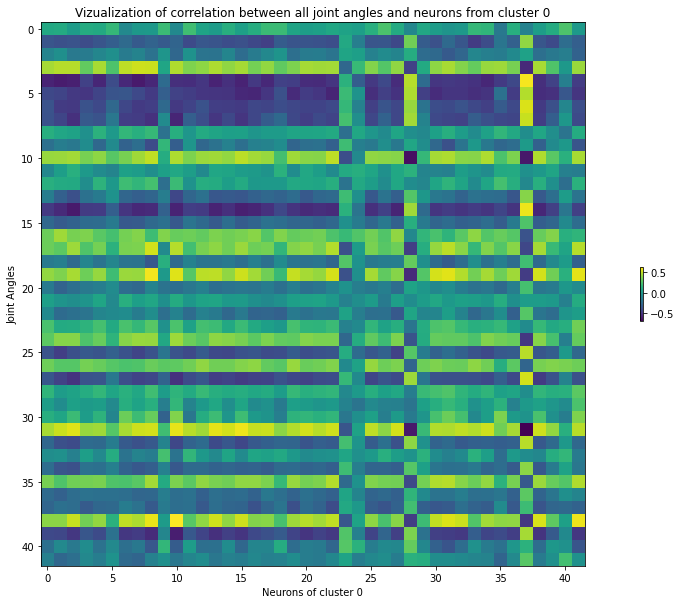

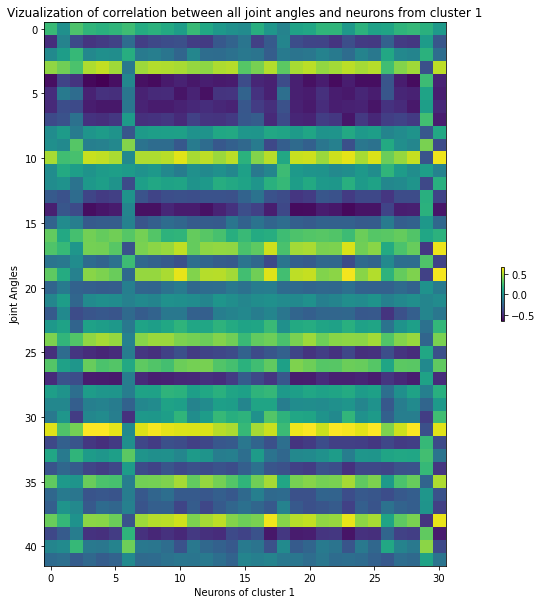

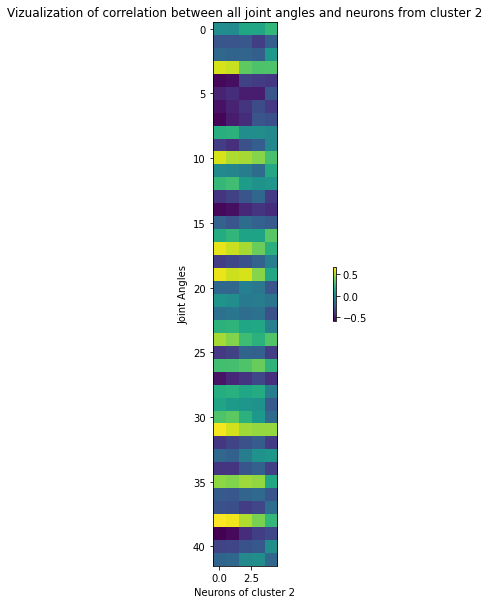

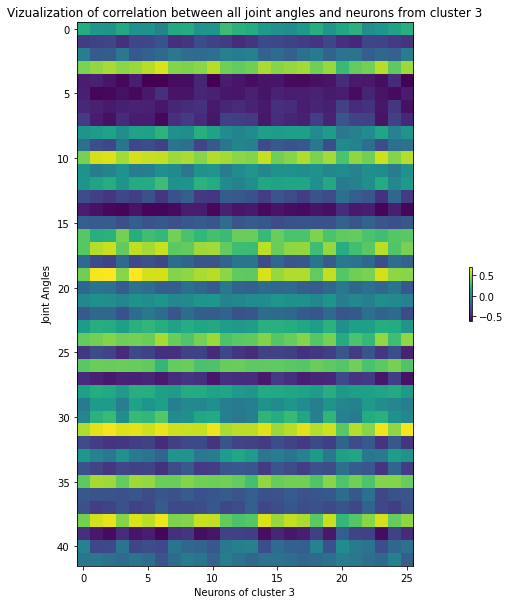

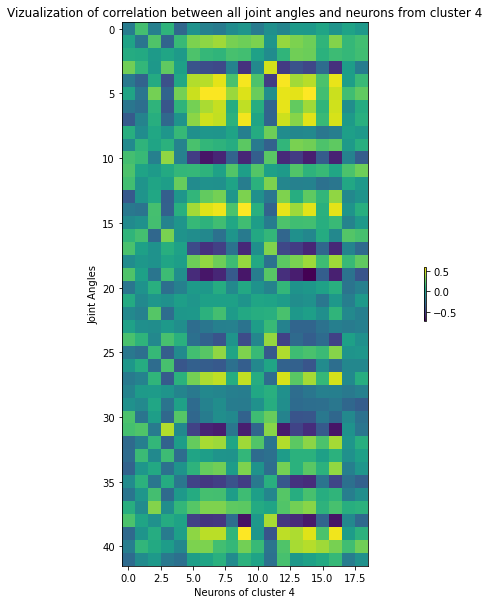

In [29]:
#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
from scipy import stats

for k in range (5):
    val = np.zeros((5,len(compare[k])))
    
    ### correlation between neural data and behavioral data
    nbr_beh_param = filtered_beh_df.filter(regex='angle').columns
    correlation = np.zeros((len(nbr_beh_param),len(compare[k])))

    #DONE ONLY FOR TRIAL 0
    for i in range (len(nbr_beh_param)): 
        twop_index = filtered_beh_df[filtered_beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
        values = filtered_beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[i]].to_numpy()
        angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
        for j in range (len(compare[k])) : 
            a=stats.spearmanr(std_Df_f['neuron_'+str(compare[k][j])][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
            correlation[i,j]=a[0]
    #plot
    name='fig_cluster_'+str(k)
    name_ax='fig_ax_'+str(k)
    name, name_ax = plt.subplots(figsize = (20,10))
    name_ax.set_title('Vizualization of correlation between all joint angles and neurons from cluster '+str(k))
    name_ax.set_ylabel('Joint Angles')
    name_ax.set_xlabel('Neurons of cluster '+str(k))
    plt.imshow(correlation)
    plt.colorbar(shrink=0.6)
    plt.show()
    name.savefig('report_images/corr_btw_joint_angles_neuron_cluster'+str(k)+'.png')

# 5. Classifying behavior from neural data
### A. Predicting one behavior
### A.1 Using one neuron

In [14]:
#create list for storing the index corresponding to the frame with nans
indx=[]
reduced=[]

In [15]:
#try out functions with beh categories
for j in range(0,12):
    twop_index = filtered_beh_df.loc[(210301, "J1xCI9",1,j), "twop_index"].to_numpy()
    values = filtered_beh_df.loc[(210301, "J1xCI9",1,j), "Manual"].to_numpy()
    reduced.append(reduce_during_2p_frame(twop_index, values, function=reduce_behaviour))
    indx.append(np.where(reduced[j] =='nan'))
    reduced[j] = reduced[j][reduced[j] != 'nan']

In [16]:
#reorganize dataframe in order to remove the rows where the downsampling function gives nan as output with the 
#corresponding neuronal acitvity values across all the neurons
filtered_neurons_df=filtered_neural_df.copy(deep=True) #just be sure in case to rerun previous cells in the notebooks
#that original dataframe is not affected
filtered_neurons_df

t  neuron_0  neuron_1  neuron_2  \
Date   Genotype Fly Trial Frame                                             
210301 J1xCI9   1   0     0        1.846767  1.830262  2.302435  0.913503   
                          1        1.908333  1.896733  2.223851  0.915863   
                          2        1.969900  1.913865  2.196361  0.898505   
                          3        2.031467  1.874510  2.254948  0.856188   
                          4        2.093000  1.829596  2.342961  0.807146   
...                                     ...       ...       ...       ...   
                    11    4035   250.257500  2.437069  0.407765  3.851353   
                          4036   250.319067  2.403217  0.448867  3.802544   
                          4037   250.380600  2.407801  0.449155  3.788424   
                          4038   250.442167  2.478857  0.391827  3.878330   
                          4039   250.503733  2.599644  0.294782  4.069995   

                                 neuron_3  neuron_4  neuron_5  neuron_6  \
Date   Genotype Fly Trial Frame                                           
210301 J1xCI9   1   0     0      0.673424  0.507693  0.534641  0.236509   
                          1      0.671848  0.493673  0.499232  0.256947   
                          2      0.664598  0.482641  0.480229  0.269833   
                          3      0.656248  0.474498  0.475333  0.272971   
                          4      0.656803  0.469005  0.472947  0.271457   
...                                   ...       ...       ...       ...   
                    11    4035   6.076314  1.898427  1.288609  0.438098   
                          4036   6.119052  1.935560  1.366787  0.454012   
                          4037   6.119410  1.992323  1.448984  0.453758   
                          4038   6.055433  2.073192  1.518322  0.444656   
                          4039   5.925515  2.173827  1.578098  0.442154   

                                 neuron_7  neuron_8  ...  neuron_113  \
Date   Genotype Fly Trial Frame                      ...               
210301 J1xCI9   1   0     0      0.684245  0.588805  ...    1.076976   
                          1      0.655468  0.566063  ...    1.040678   
                          2      0.650144  0.549203  ...    1.008861   
                          3      0.660358  0.539477  ...    0.987256   
                          4      0.660709  0.538147  ...    0.976346   
...                                   ...       ...  ...         ...   
                    11    4035   4.608283  1.554365  ...    0.405355   
                          4036   4.642148  1.556720  ...    0.427632   
                          4037   4.652684  1.536832  ...    0.481182   
                          4038   4.582710  1.495086  ...    0.529576   
                          4039   4.433745  1.438210  ...    0.564194   

                                 neuron_114  neuron_115  neuron_116  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        0.768052    0.855806    1.114782   
                          1        0.731206    0.864005    1.142800   
                          2        0.700835    0.869347    1.150103   
                          3        0.681750    0.872432    1.129095   
                          4        0.673142    0.871986    1.090137   
...                                     ...         ...         ...   
                    11    4035     1.884477    0.786541    2.500893   
                          4036     1.969924    0.785018    2.515189   
                          4037     2.043410    0.785238    2.498330   
                          4038     2.112438    0.747801    2.455444   
                          4039     2.183506    0.665350    2.378206   

                                 neuron_117  neuron_118  neuron_119  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        2.053602    1.458494    2.

In [18]:
#remove rows with nan
for i in range(0,12):
    selection = filtered_neurons_df.loc[(210301, "J1xCI9", 1, i)]
    selection = filtered_neurons_df.iloc[indx[i]]
    filtered_neurons_df.drop(selection.index, inplace=True)

In [19]:
filtered_neurons_df #new dataframe

t  neuron_0  neuron_1  neuron_2  \
Date   Genotype Fly Trial Frame                                             
210301 J1xCI9   1   0     0        1.846767  1.830262  2.302435  0.913503   
                          1        1.908333  1.896733  2.223851  0.915863   
                          2        1.969900  1.913865  2.196361  0.898505   
                          3        2.031467  1.874510  2.254948  0.856188   
                          4        2.093000  1.829596  2.342961  0.807146   
...                                     ...       ...       ...       ...   
                    11    4035   250.257500  2.437069  0.407765  3.851353   
                          4036   250.319067  2.403217  0.448867  3.802544   
                          4037   250.380600  2.407801  0.449155  3.788424   
                          4038   250.442167  2.478857  0.391827  3.878330   
                          4039   250.503733  2.599644  0.294782  4.069995   

                                 neuron_3  neuron_4  neuron_5  neuron_6  \
Date   Genotype Fly Trial Frame                                           
210301 J1xCI9   1   0     0      0.673424  0.507693  0.534641  0.236509   
                          1      0.671848  0.493673  0.499232  0.256947   
                          2      0.664598  0.482641  0.480229  0.269833   
                          3      0.656248  0.474498  0.475333  0.272971   
                          4      0.656803  0.469005  0.472947  0.271457   
...                                   ...       ...       ...       ...   
                    11    4035   6.076314  1.898427  1.288609  0.438098   
                          4036   6.119052  1.935560  1.366787  0.454012   
                          4037   6.119410  1.992323  1.448984  0.453758   
                          4038   6.055433  2.073192  1.518322  0.444656   
                          4039   5.925515  2.173827  1.578098  0.442154   

                                 neuron_7  neuron_8  ...  neuron_113  \
Date   Genotype Fly Trial Frame                      ...               
210301 J1xCI9   1   0     0      0.684245  0.588805  ...    1.076976   
                          1      0.655468  0.566063  ...    1.040678   
                          2      0.650144  0.549203  ...    1.008861   
                          3      0.660358  0.539477  ...    0.987256   
                          4      0.660709  0.538147  ...    0.976346   
...                                   ...       ...  ...         ...   
                    11    4035   4.608283  1.554365  ...    0.405355   
                          4036   4.642148  1.556720  ...    0.427632   
                          4037   4.652684  1.536832  ...    0.481182   
                          4038   4.582710  1.495086  ...    0.529576   
                          4039   4.433745  1.438210  ...    0.564194   

                                 neuron_114  neuron_115  neuron_116  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        0.768052    0.855806    1.114782   
                          1        0.731206    0.864005    1.142800   
                          2        0.700835    0.869347    1.150103   
                          3        0.681750    0.872432    1.129095   
                          4        0.673142    0.871986    1.090137   
...                                     ...         ...         ...   
                    11    4035     1.884477    0.786541    2.500893   
                          4036     1.969924    0.785018    2.515189   
                          4037     2.043410    0.785238    2.498330   
                          4038     2.112438    0.747801    2.455444   
                          4039     2.183506    0.665350    2.378206   

                                 neuron_117  neuron_118  neuron_119  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        2.053602    1.458494    2.

In [20]:
filtered_neural_df #original dataframe unchanged

t  neuron_0  neuron_1  neuron_2  \
Date   Genotype Fly Trial Frame                                             
210301 J1xCI9   1   0     0        1.846767  1.830262  2.302435  0.913503   
                          1        1.908333  1.896733  2.223851  0.915863   
                          2        1.969900  1.913865  2.196361  0.898505   
                          3        2.031467  1.874510  2.254948  0.856188   
                          4        2.093000  1.829596  2.342961  0.807146   
...                                     ...       ...       ...       ...   
                    11    4035   250.257500  2.437069  0.407765  3.851353   
                          4036   250.319067  2.403217  0.448867  3.802544   
                          4037   250.380600  2.407801  0.449155  3.788424   
                          4038   250.442167  2.478857  0.391827  3.878330   
                          4039   250.503733  2.599644  0.294782  4.069995   

                                 neuron_3  neuron_4  neuron_5  neuron_6  \
Date   Genotype Fly Trial Frame                                           
210301 J1xCI9   1   0     0      0.673424  0.507693  0.534641  0.236509   
                          1      0.671848  0.493673  0.499232  0.256947   
                          2      0.664598  0.482641  0.480229  0.269833   
                          3      0.656248  0.474498  0.475333  0.272971   
                          4      0.656803  0.469005  0.472947  0.271457   
...                                   ...       ...       ...       ...   
                    11    4035   6.076314  1.898427  1.288609  0.438098   
                          4036   6.119052  1.935560  1.366787  0.454012   
                          4037   6.119410  1.992323  1.448984  0.453758   
                          4038   6.055433  2.073192  1.518322  0.444656   
                          4039   5.925515  2.173827  1.578098  0.442154   

                                 neuron_7  neuron_8  ...  neuron_113  \
Date   Genotype Fly Trial Frame                      ...               
210301 J1xCI9   1   0     0      0.684245  0.588805  ...    1.076976   
                          1      0.655468  0.566063  ...    1.040678   
                          2      0.650144  0.549203  ...    1.008861   
                          3      0.660358  0.539477  ...    0.987256   
                          4      0.660709  0.538147  ...    0.976346   
...                                   ...       ...  ...         ...   
                    11    4035   4.608283  1.554365  ...    0.405355   
                          4036   4.642148  1.556720  ...    0.427632   
                          4037   4.652684  1.536832  ...    0.481182   
                          4038   4.582710  1.495086  ...    0.529576   
                          4039   4.433745  1.438210  ...    0.564194   

                                 neuron_114  neuron_115  neuron_116  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        0.768052    0.855806    1.114782   
                          1        0.731206    0.864005    1.142800   
                          2        0.700835    0.869347    1.150103   
                          3        0.681750    0.872432    1.129095   
                          4        0.673142    0.871986    1.090137   
...                                     ...         ...         ...   
                    11    4035     1.884477    0.786541    2.500893   
                          4036     1.969924    0.785018    2.515189   
                          4037     2.043410    0.785238    2.498330   
                          4038     2.112438    0.747801    2.455444   
                          4039     2.183506    0.665350    2.378206   

                                 neuron_117  neuron_118  neuron_119  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        2.053602    1.458494    2.

In [ ]:
print(len(reduced[0][:])) #check dimensions

In [21]:
#concatenate all of the behavioral labels of the singles trials in one variable
reducedv=np.concatenate((reduced[0][:],reduced[1][:],reduced[2][:],reduced[3][:],reduced[4][:],reduced[5][:],reduced[6][:],reduced[7][:],reduced[8][:],reduced[9][:],reduced[10][:],reduced[11][:]),axis=None)
len(reducedv)

47478

In [22]:
# prepare binary variable for walking to indicate whether fly is walking or not
bin_var_walk=np.where(reducedv=='walking',1,0)
bin_var_walk= bin_var_walk.tolist()
print(len(bin_var_walk)) #check if length matches

47478


In [24]:
def logreg_1binvar(X,y):   
    """
    Uses logistic regression with one or multiple neuron's activities as input and binary variable that indicates
    whether the fly is exhibiting a certain behavior or not as output of the model.
    First the datset is stratified split into train and test then some preprocessing is done. The classifier
    is built, trained and then the predictions are made on the test data with a brief visualization of the
    prediction given.
    A classification report is then given which gives a measure of the quality of the prediction from the 
    classificatio algorithm. A confusion matrix is plotted in order to give a visualization of the results.
    Parameters
    ----------
    X : numpy matrix
        Matrix holding the regressors.
    y : numpy list
        List holding all the behavioral labels
    Returns
    -------
    model : sklearn object
        Logistic regression model.
    """
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    #preprocessing
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #check the proportions of the two labels in the train and test, stratify assures proportions are the same
    #if not stratified and the two labels have very different quantities in the test or train
    #there may not be any of one of the two labels making the training unconclusive
    print(Counter(y_train)) #sanity check of the labels
    print(Counter(y_test))
    
    #build the classifier and train it
    model = LogisticRegression(random_state=10) #fixed random state
    model.fit(X_train, y_train)
    
    #make prediction and print classification report
    y_pred = pd.Series(model.predict(X_test))
    y_test = pd.Series(y_test)
    z = pd.concat([y_test, y_pred], axis=1)
    z.columns = ['True', 'Prediction']
    print(z.head())
    print('\n')
    print(metrics.classification_report(y_test, y_pred))
    
    #get confusion matrix and print it
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    labels = [0, 1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    return model

In [25]:
#create a dataframe in order to sort the neurons by their correlation coefficient with the walking binary variable
#obtained from previous computations in other parts, more neurons will be subsequently added as regressors
#the neurons are sorted by decreasing order
sorted_neurons=['neuron_21', 'neuron_58', 'neuron_82', 'neuron_92', 'neuron_14', 'neuron_38', 'neuron_51', 'neuron_12', 'neuron_10', 'neuron_48', 'neuron_118', 'neuron_105', 'neuron_11', 'neuron_116', 'neuron_91', 'neuron_34', 'neuron_85', 'neuron_114', 'neuron_115', 'neuron_22', 'neuron_23', 'neuron_5', 'neuron_32', 'neuron_20', 'neuron_121', 'neuron_26', 'neuron_120', 'neuron_79', 'neuron_99', 'neuron_101', 'neuron_96', 'neuron_8', 'neuron_97', 'neuron_73', 'neuron_33', 'neuron_47', 'neuron_25', 'neuron_9', 'neuron_36', 'neuron_57', 'neuron_29', 'neuron_100', 'neuron_93', 'neuron_28', 'neuron_117', 'neuron_35', 'neuron_60', 'neuron_56', 'neuron_90', 'neuron_68', 'neuron_49', 'neuron_75', 'neuron_4', 'neuron_62', 'neuron_46', 'neuron_102', 'neuron_16', 'neuron_88', 'neuron_65', 'neuron_54', 'neuron_106', 'neuron_78', 'neuron_17', 'neuron_103', 'neuron_89', 'neuron_63', 'neuron_41', 'neuron_24', 'neuron_77', 'neuron_107', 'neuron_15', 'neuron_83', 'neuron_84', 'neuron_71', 'neuron_31', 'neuron_1', 'neuron_42', 'neuron_39', 'neuron_94', 'neuron_0', 'neuron_74', 'neuron_76', 'neuron_70', 'neuron_37', 'neuron_6', 'neuron_66', 'neuron_30', 'neuron_72', 'neuron_13', 'neuron_18', 'neuron_108', 'neuron_44', 'neuron_3', 'neuron_50', 'neuron_104', 'neuron_69', 'neuron_86', 'neuron_111', 'neuron_43', 'neuron_113']
sort100_filtered_neural_df=filtered_neurons_df.reindex(columns=sorted_neurons)
sort100_filtered_neural_df

neuron_21  neuron_58  neuron_82  neuron_92  \
Date   Genotype Fly Trial Frame                                               
210301 J1xCI9   1   0     0       0.318577   0.577028   0.701083   0.364171   
                          1       0.335087   0.569102   0.647614   0.370210   
                          2       0.351363   0.571483   0.620407   0.368803   
                          3       0.363854   0.582141   0.616211   0.363200   
                          4       0.365302   0.586783   0.617443   0.361787   
...                                    ...        ...        ...        ...   
                    11    4035    0.928840   0.529797   0.833848   0.810034   
                          4036    0.896058   0.561794   0.892568   0.818491   
                          4037    0.861573   0.569366   0.933463   0.814140   
                          4038    0.839689   0.562377   0.925626   0.808921   
                          4039    0.824642   0.565353   0.876184   0.808979   

                                 neuron_14  neuron_38  neuron_51  neuron_12  \
Date   Genotype Fly Trial Frame                                               
210301 J1xCI9   1   0     0       0.573358   0.483583   0.190515   0.494567   
                          1       0.599533   0.486479   0.231991   0.469153   
                          2       0.611120   0.479230   0.252516   0.450740   
                          3       0.604687   0.465959   0.251577   0.446185   
                          4       0.588363   0.456616   0.242836   0.450911   
...                                    ...        ...        ...        ...   
                    11    4035    1.779669   1.628995   0.910157   2.107102   
                          4036    1.755210   1.628647   0.915487   2.097252   
                          4037    1.724616   1.647448   0.950121   2.050421   
                          4038    1.720158   1.683744   0.995809   2.051767   
                          4039    1.746897   1.722045   1.031271   2.128350   

                                 neuron_10  neuron_48  ...  neuron_108  \
Date   Genotype Fly Trial Frame                        ...               
210301 J1xCI9   1   0     0       0.218194   0.468060  ...    0.583090   
                          1       0.256498   0.461287  ...    0.563702   
                          2       0.268329   0.452161  ...    0.544293   
                          3       0.260594   0.443611  ...    0.530457   
                          4       0.249975   0.437240  ...    0.525617   
...                                    ...        ...  ...         ...   
                    11    4035    0.687161   1.572850  ...    1.505551   
                          4036    0.691659   1.691234  ...    1.514016   
                          4037    0.695724   1.738233  ...    1.521249   
                          4038    0.691142   1.649397  ...    1.496838   
                          4039    0.675036   1.451662  ...    1.437153   

                                 neuron_44  neuron_3  neuron_50  neuron_104  \
Date   Genotype Fly Trial Frame                                               
210301 J1xCI9   1   0     0       1.558347  0.673424   1.147128    1.343664   
                          1       1.701776  0.671848   1.169191    1.312721   
                          2       1.784226  0.664598   1.180524    1.289817   
                          3       1.791340  0.656248   1.182573    1.282971   
                          4       1.760888  0.656803   1.181845    1.298253   
...                                    ...       ...        ...         ...   
                    11    4035    1.946301  6.076314   0.716369    1.125851   
                          4036    2.055568  6.119052   0.716945    1.146462   
                          4037    2.137911  6.119410   0.712650    1.152585   
                          4038    2.194238  6.055433   0.695235    1.163758   
                          4039    2.244026  5.925515   0.663074   

Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})
   True  Prediction
0     0           0
1     1           1
2     1           1
3     1           0
4     1           1


              precision    recall  f1-score   support

           0       0.57      0.61      0.59      4668
           1       0.60      0.56      0.58      4828

    accuracy                           0.58      9496
   macro avg       0.58      0.58      0.58      9496
weighted avg       0.58      0.58      0.58      9496



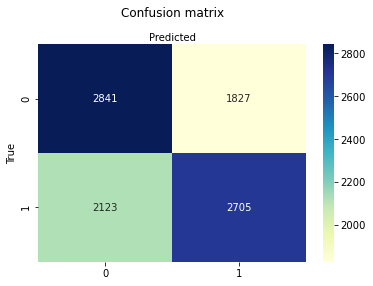

In [26]:
#choose the highest correlated neuron as regressors for the predction of the binary walking behavior
neuron_21 = sort100_filtered_neural_df.loc[(210301, "J1xCI9", 1), "neuron_21"]
X=np.expand_dims(neuron_21, axis=1)

#make prediction with classifier
log_reg_walk= logreg_1binvar(X,bin_var_walk)

As we can see the prediction is quite poor.

### A.2 Adding more neurons as regressors

Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})
   True  Prediction
0     0           0
1     1           1
2     0           1
3     0           0
4     0           0


              precision    recall  f1-score   support

           0       0.59      0.56      0.58      4668
           1       0.60      0.63      0.61      4828

    accuracy                           0.60      9496
   macro avg       0.60      0.60      0.60      9496
weighted avg       0.60      0.60      0.60      9496



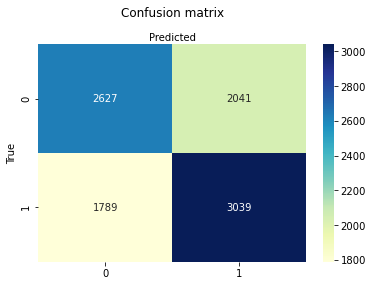

In [28]:
#start increasing the number of regressors and see how the classifier prediction evolves
#try with the frist two neurons

chosen_neurons=sort100_filtered_neural_df.loc[:,'neuron_21':'neuron_58']
chosen_neurons=chosen_neurons.loc[(210301, "J1xCI9", 1)]
#train classifier
log_reg_walk2= logreg_1binvar(chosen_neurons,bin_var_walk)


Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})
   True  Prediction
0     0           1
1     0           0
2     1           1
3     1           1
4     1           0


              precision    recall  f1-score   support

           0       0.59      0.57      0.58      4668
           1       0.60      0.62      0.61      4828

    accuracy                           0.60      9496
   macro avg       0.60      0.60      0.60      9496
weighted avg       0.60      0.60      0.60      9496



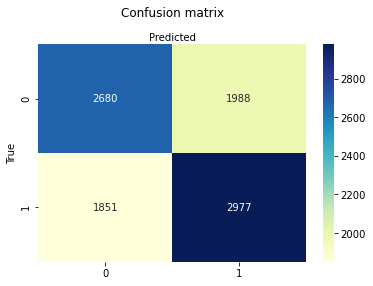

In [35]:
#6 regressors
chosen_neurons=sort100_filtered_neural_df.iloc[:,0:6]
chosen_neurons=chosen_neurons.loc[(210301, "J1xCI9", 1)]

#train classifier
log_reg_walk6= logreg_1binvar(chosen_neurons,bin_var_walk)

Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})
   True  Prediction
0     0           0
1     0           1
2     1           0
3     1           0
4     1           1


              precision    recall  f1-score   support

           0       0.61      0.65      0.63      4668
           1       0.64      0.59      0.61      4828

    accuracy                           0.62      9496
   macro avg       0.62      0.62      0.62      9496
weighted avg       0.62      0.62      0.62      9496



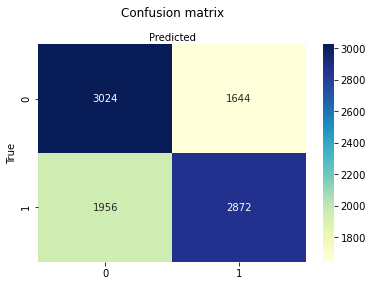

In [36]:
#12 regressors
chosen_neurons=sort100_filtered_neural_df.iloc[:,0:12]
chosen_neurons=chosen_neurons.loc[(210301, "J1xCI9", 1)]

#train classifier
log_reg_walk12= logreg_1binvar(chosen_neurons,bin_var_walk)

Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})
   True  Prediction
0     0           0
1     0           1
2     1           1
3     1           1
4     1           1


              precision    recall  f1-score   support

           0       0.63      0.65      0.64      4668
           1       0.65      0.63      0.64      4828

    accuracy                           0.64      9496
   macro avg       0.64      0.64      0.64      9496
weighted avg       0.64      0.64      0.64      9496



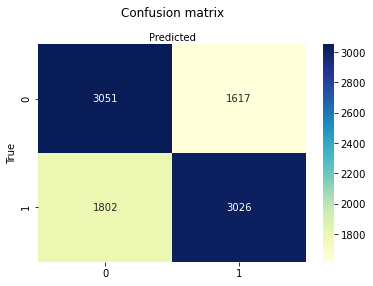

In [38]:
#25 regressors
chosen_neurons=sort100_filtered_neural_df.iloc[:,0:25]
chosen_neurons=chosen_neurons.loc[(210301, "J1xCI9", 1)]

#train classifier
log_reg_walk25= logreg_1binvar(chosen_neurons,bin_var_walk)

Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})
   True  Prediction
0     0           1
1     1           0
2     1           1
3     0           0
4     1           0


              precision    recall  f1-score   support

           0       0.66      0.66      0.66      4668
           1       0.67      0.67      0.67      4828

    accuracy                           0.66      9496
   macro avg       0.66      0.66      0.66      9496
weighted avg       0.66      0.66      0.66      9496



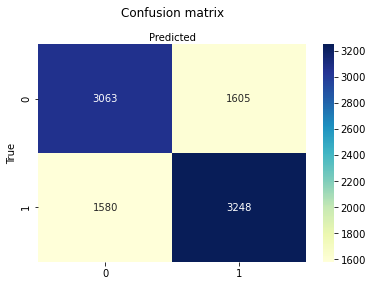

In [39]:
#50 regressors
chosen_neurons=sort100_filtered_neural_df.iloc[:,0:50]
chosen_neurons=chosen_neurons.loc[(210301, "J1xCI9", 1)]

#train classifier
log_reg_walk50= logreg_1binvar(chosen_neurons,bin_var_walk)

Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   True  Prediction
0     1           1
1     0           0
2     0           0
3     0           0
4     1           1


              precision    recall  f1-score   support

           0       0.69      0.67      0.68      4668
           1       0.69      0.70      0.70      4828

    accuracy                           0.69      9496
   macro avg       0.69      0.69      0.69      9496
weighted avg       0.69      0.69      0.69      9496



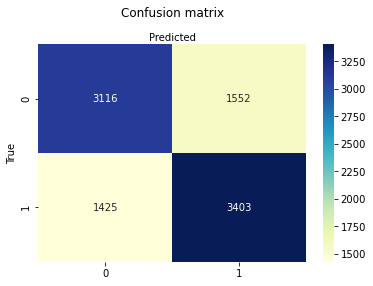

In [41]:
#100 regressors
chosen_neurons=sort100_filtered_neural_df.iloc[:,0:100]
chosen_neurons=chosen_neurons.loc[(210301, "J1xCI9", 1)]

#train classifier
log_reg_walk100= logreg_1binvar(chosen_neurons,bin_var_walk)

Very similar performance results from 25 to 100 regressors.

Counter({1: 19312, 0: 18670})
Counter({1: 4828, 0: 4668})
   True  Prediction
0     1           1
1     0           0
2     0           0
3     0           0
4     1           1


              precision    recall  f1-score   support

           0       0.69      0.68      0.68      4668
           1       0.69      0.70      0.70      4828

    accuracy                           0.69      9496
   macro avg       0.69      0.69      0.69      9496
weighted avg       0.69      0.69      0.69      9496



Text(0.5, 15.0, 'Predicted')

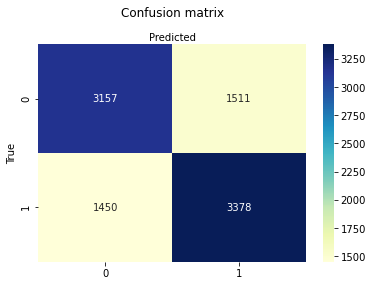

In [46]:
#all the neurons
neurons=filtered_neurons_df.iloc[:,0:124]
neurons=neurons.loc[(210301, "J1xCI9", 1)]
X_train, X_test, y_train, y_test = train_test_split(neurons, bin_var_walk, test_size=0.2, stratify=bin_var_walk)
    
    #preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    
    #check the proportions of the two labels in the train and test, stratify assures proportions are the same
    #if not stratified and the two labels have very different quantities in the test or train
    #there may not be any of one of the two labels making the training unconclusive
print(Counter(y_train))
print(Counter(y_test))
    
    #build the classifier and train it
model = LogisticRegression(max_iter=1000,random_state=10) #increased max iteration in order to reach convergence, 
#however even without that results are basically the same which speaks for the classifier being quite stable despite 
#not converging
model.fit(X_train, y_train)
    
    #make prediction and print classification report
y_pred = pd.Series(model.predict(X_test))
y_test = pd.Series(y_test)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
print(z.head())
print('\n')
print(metrics.classification_report(y_test, y_pred))
    #get confusion matrix and print it
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

### A.3 Including all neurons in the analysis:


In [47]:
coeff = model.coef_
print(coeff)
print(np.count_nonzero((abs(coeff))>=0.2))

[[-0.06991294  0.07751705 -0.07772474  0.13190517 -0.22118811  0.1080605
  -0.5086149   0.27596728 -0.11994079 -0.18962829  0.07232105 -0.03217095
   0.11567415  0.5316578   0.04884174  0.24103836  0.21737477 -0.016577
  -0.08648059 -0.0478004  -0.08327762 -0.32017291  0.1763549   0.03956005
  -0.31451131  0.23763236 -0.09314419  0.08204614  0.17443814 -0.26071596
  -0.18299368 -0.21264838  0.07182614  0.10843679  0.30192339  0.34142992
  -0.11807294 -0.11851247 -0.05983316  0.33370603 -0.10793282  0.04604128
   0.25407923 -0.05883708  0.10342544  0.79399481  0.24903664 -0.30990736
  -0.29572295 -0.41600062 -0.04989097  0.01957817  0.01053646  0.21666878
  -0.42227633  0.11849371  0.06854152 -0.20180279 -0.23505201 -0.09263839
   0.00397949 -0.16279036 -0.10258742 -0.39487724 -0.08618774 -0.13546101
   0.36392887  0.13539405  0.22509493  0.09715411  0.09245771 -0.16557207
   0.0270915   0.0352947   0.03767163  0.0084546   0.17250954 -0.32632607
  -0.00470997 -0.13111264 -0.01817595  0.

If we consider as meaningful just the weights whose absolute value is >=0.2 then just 38 out of 123 Neurons are taken into consideration by the classifier. 

### A.4 Part 2.1.4
Try the same thing with other behaviours (e.g., anterior grooming). Can you classify
those with the same accuracy?

In [48]:
# reduce binary variable for every behavior
#resting
bin_var_rest=np.where(reducedv=='resting',1,0)
bin_var_rest= bin_var_rest.tolist()
#ab_push
bin_var_ap=np.where(reducedv=='abdominal_pushing',1,0)
bin_var_ap= bin_var_ap.tolist()
#ant_groom
bin_var_ag=np.where(reducedv=='anterior_grooming',1,0)
bin_var_ag= bin_var_ag.tolist()
#post_groom not sure if to include as it is super rare beahvior
bin_var_pg=np.where(reducedv=='posterior_grooming',1,0)
bin_var_pg= bin_var_pg.tolist()

Resting
Counter({0: 24299, 1: 13683})
Counter({0: 6075, 1: 3421})
   True  Prediction
0     0           0
1     0           0
2     0           0
3     1           0
4     0           0


              precision    recall  f1-score   support

           0       0.71      0.89      0.79      6075
           1       0.64      0.35      0.45      3421

    accuracy                           0.69      9496
   macro avg       0.67      0.62      0.62      9496
weighted avg       0.68      0.69      0.67      9496



Text(0.5, 15.0, 'Predicted')

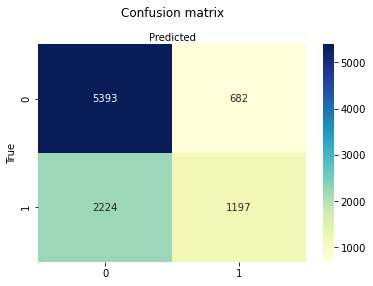

In [51]:
# train and test with binary resting varaibles and other behaviors
print("Resting")
neurons=filtered_neurons_df.iloc[:,0:124]
neurons=neurons.loc[(210301, "J1xCI9", 1)]
X_train, X_test, y_train, y_test = train_test_split(neurons, bin_var_rest, test_size=0.2, stratify=bin_var_rest)
    
    #preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    
    #check the proportions of the two labels in the train and test, stratify assures proportions are the same
    #if not stratified and the two labels have very different quantities in the test or train
    #there may not be any of one of the two labels making the training unconclusive
print(Counter(y_train))
print(Counter(y_test))
    
    #build the classifier and train it
model = LogisticRegression(max_iter=1000,random_state=10) #increased max iteration in order to reach convergence, 
#however even without that results are basically the same which speaks for the classifier being quite stable despite 
#not converging
model.fit(X_train, y_train)
    
    #make prediction and print classification report
y_pred = pd.Series(model.predict(X_test))
y_test = pd.Series(y_test)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
print(z.head())
print('\n')
print(metrics.classification_report(y_test, y_pred))
    #get confusion matrix and print it
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

Abdnominal pushing
Counter({0: 37021, 1: 961})
Counter({0: 9256, 1: 240})
   True  Prediction
0     0           0
1     0           0
2     0           0
3     0           0
4     0           0


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9256
           1       0.94      0.71      0.81       240

    accuracy                           0.99      9496
   macro avg       0.97      0.85      0.90      9496
weighted avg       0.99      0.99      0.99      9496



Text(0.5, 15.0, 'Predicted')

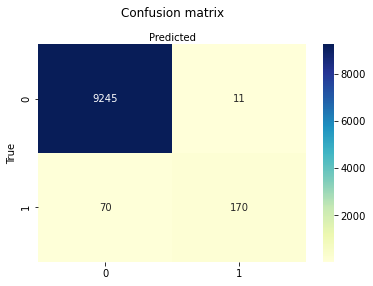

In [52]:
print("Abdnominal pushing")
neurons=filtered_neurons_df.iloc[:,0:124]
neurons=neurons.loc[(210301, "J1xCI9", 1)]
X_train, X_test, y_train, y_test = train_test_split(neurons, bin_var_ap, test_size=0.2, stratify=bin_var_ap)
    
    #preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    
    #check the proportions of the two labels in the train and test, stratify assures proportions are the same
    #if not stratified and the two labels have very different quantities in the test or train
    #there may not be any of one of the two labels making the training unconclusive
print(Counter(y_train))
print(Counter(y_test))
    
    #build the classifier and train it
model = LogisticRegression(max_iter=1000,random_state=10) #increased max iteration in order to reach convergence, 
#however even without that results are basically the same which speaks for the classifier being quite stable despite 
#not converging
model.fit(X_train, y_train)
    
    #make prediction and print classification report
y_pred = pd.Series(model.predict(X_test))
y_test = pd.Series(y_test)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
print(z.head())
print('\n')
print(metrics.classification_report(y_test, y_pred))
    #get confusion matrix and print it
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

Anterior Grooming
Counter({0: 34217, 1: 3765})
Counter({0: 8555, 1: 941})
   True  Prediction
0     0           0
1     1           0
2     0           0
3     0           0
4     0           0


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8555
           1       0.55      0.06      0.10       941

    accuracy                           0.90      9496
   macro avg       0.73      0.53      0.53      9496
weighted avg       0.87      0.90      0.86      9496



Text(0.5, 15.0, 'Predicted')

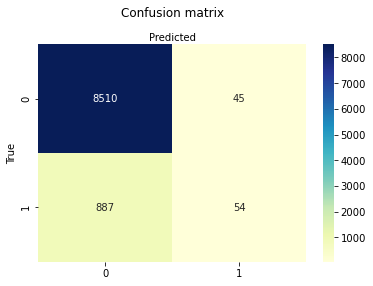

In [54]:
print("Anterior Grooming")
neurons=filtered_neurons_df.iloc[:,0:124]
neurons=neurons.loc[(210301, "J1xCI9", 1)]
X_train, X_test, y_train, y_test = train_test_split(neurons, bin_var_ag, test_size=0.2, stratify=bin_var_ag)
    
    #preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    
    #check the proportions of the two labels in the train and test, stratify assures proportions are the same
    #if not stratified and the two labels have very different quantities in the test or train
    #there may not be any of one of the two labels making the training unconclusive
print(Counter(y_train))
print(Counter(y_test))
    
    #build the classifier and train it
model = LogisticRegression(max_iter=1000,random_state=10) #increased max iteration in order to reach convergence, 
#however even without that results are basically the same which speaks for the classifier being quite stable despite 
#not converging
model.fit(X_train, y_train)
    
    #make prediction and print classification report
y_pred = pd.Series(model.predict(X_test))
y_test = pd.Series(y_test)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
print(z.head())
print('\n')
print(metrics.classification_report(y_test, y_pred))
    #get confusion matrix and print it
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

Posterior Grooming 
As this behavior is very rare
Counter({0: 37720, 1: 262})
Counter({0: 9431, 1: 65})
   True  Prediction
0     0           0
1     0           0
2     0           0
3     0           0
4     0           0


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9431
           1       0.92      0.17      0.29        65

    accuracy                           0.99      9496
   macro avg       0.96      0.58      0.64      9496
weighted avg       0.99      0.99      0.99      9496



Text(0.5, 15.0, 'Predicted')

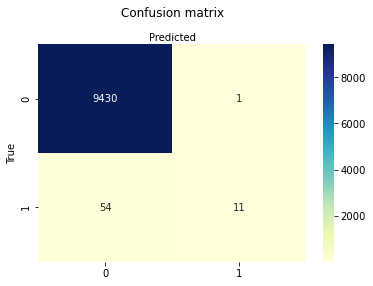

In [55]:
print("Posterior Grooming \nAs this behavior is very rare")
neurons=filtered_neurons_df.iloc[:,0:124]
neurons=neurons.loc[(210301, "J1xCI9", 1)]
X_train, X_test, y_train, y_test = train_test_split(neurons, bin_var_pg, test_size=0.2, stratify=bin_var_pg)
    
    #preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    
    #check the proportions of the two labels in the train and test, stratify assures proportions are the same
    #if not stratified and the two labels have very different quantities in the test or train
    #there may not be any of one of the two labels making the training unconclusive
print(Counter(y_train))
print(Counter(y_test))
    
    #build the classifier and train it
model = LogisticRegression(max_iter=1000,random_state=10) #increased max iteration in order to reach convergence, 
#however even without that results are basically the same which speaks for the classifier being quite stable despite 
#not converging
model.fit(X_train, y_train)
    
    #make prediction and print classification report
y_pred = pd.Series(model.predict(X_test))
y_test = pd.Series(y_test)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
print(z.head())
print('\n')
print(metrics.classification_report(y_test, y_pred))
    #get confusion matrix and print it
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

We can see here a comparison between the different behaviors for their prediction with always a binary variable as output.

## B. Predicting multiple behaviours


### B.1. Predict all behaviours at once with multi-class logistic regression. 

In [56]:
# assign variables to every behavior
#Mult_beh_var=np.unique(reduced,return_inverse=True)[1].tolist()
my_dict = {'resting': 0, 'walking': 1, 'abdominal_pushing': 2, 'anterior_grooming': 3, 'posterior_grooming': 4}
Mult_beh_var=[my_dict[zi] for zi in reducedv]

Counter({1: 19312, 0: 13683, 3: 3765, 2: 961, 4: 261})
Counter({1: 4828, 0: 3421, 3: 941, 2: 240, 4: 66})
   True  Prediction
0     3           3
1     1           0
2     1           1
3     3           1
4     0           0
              precision    recall  f1-score   support

           0       0.58      0.51      0.54      3421
           1       0.66      0.79      0.72      4828
           2       0.83      0.81      0.82       240
           3       0.46      0.19      0.27       941
           4       0.77      0.35      0.48        66

    accuracy                           0.63      9496
   macro avg       0.66      0.53      0.57      9496
weighted avg       0.62      0.63      0.61      9496



Text(0.5, 15.0, 'Predicted')

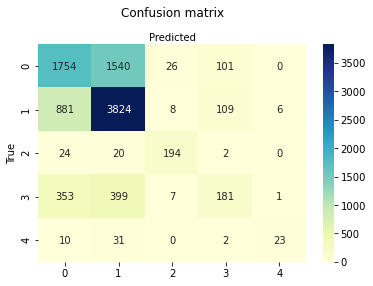

In [71]:
X_train, X_test, y_train, y_test = train_test_split(neurons, Mult_beh_var, test_size=0.2, stratify=Mult_beh_var)
    #preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    #check if there may have been a problem with could be resolved with stratified split
print(Counter(y_train))
print(Counter(y_test))
    #build the classifier and train it
model = LogisticRegression(max_iter=1500,random_state=10) #multiclass left to auto settings
model.fit(X_train, y_train)
    #make prediction and give brief visualization of prediction
y_pred = pd.Series(model.predict(X_test))
y_test = pd.Series(y_test)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
print(z.head())
print(metrics.classification_report(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

In [72]:
coeff = model.coef_
print(coeff)
for i in range(5):
    print(np.count_nonzero((abs(coeff[i,:]))>=0.2))

[[ 7.22028384e-01 -4.46729316e-01 -3.73080767e-02  1.19842201e+00
  -4.71656503e-02  1.28988168e-01  4.41002586e-01  6.16821084e-01
  -5.31568908e-01  1.66850721e-01  1.58404357e-01  3.50005124e-01
   4.03431200e-01  4.57499839e-01  1.96175597e-01 -5.09684751e-01
   7.23963740e-01 -2.93570003e-01  1.53234632e-01  3.24990835e-01
   2.51265873e-01 -5.07933791e-01  1.24349944e-03 -3.95319554e-01
   1.30047174e-01 -3.14603756e-01 -3.24846052e-01 -4.36569251e-01
  -2.83244161e-01  1.65503768e+00 -1.50468124e-01 -1.20164156e-02
   1.44027344e-01 -1.42288482e-01  8.21602755e-02 -7.00755417e-02
  -1.32828003e-01 -2.90788812e-01 -3.11282026e-01  2.75927311e-01
   4.25861112e-02  1.24165182e-01  3.60786887e-01  3.01190697e-01
  -3.61372386e-01  1.44711798e-03  7.54587525e-02  2.81674793e-01
  -2.60158067e-01  4.23097703e-01 -1.32453151e-01  2.71383082e-01
  -1.41428217e-02 -7.07118175e-01 -1.29245051e-01 -7.11026418e-02
   6.16484276e-02 -4.46791718e-01  2.35216828e-01  6.32146266e-02
   2.01267

Multiple neurons contribute to the prediction.

## B.2 Using a more advanced classifier

In [59]:
from sklearn.neural_network import MLPClassifier

Counter({1: 19312, 0: 13683, 3: 3765, 2: 961, 4: 261})
Counter({1: 4828, 0: 3421, 3: 941, 2: 240, 4: 66})


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


   True  Prediction
0     0           0
1     0           0
2     0           0
3     0           0
4     0           0
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3421
           1       0.92      0.96      0.94      4828
           2       0.94      0.97      0.96       240
           3       0.86      0.85      0.86       941
           4       0.92      0.82      0.86        66

    accuracy                           0.93      9496
   macro avg       0.92      0.90      0.91      9496
weighted avg       0.93      0.93      0.93      9496



Text(0.5, 15.0, 'Predicted')

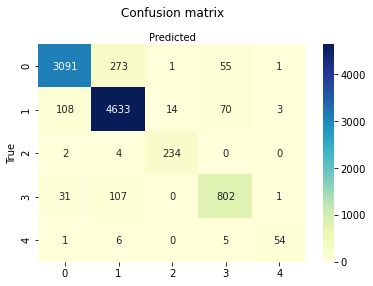

In [60]:
X_train, X_test, y_train, y_test = train_test_split(neurons, Mult_beh_var, test_size=0.2, stratify=Mult_beh_var)
    #preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    #check if there may have been a problem with could be resolved with stratified split
print(Counter(y_train))
print(Counter(y_test))
    #build the classifier and train it
model =  MLPClassifier(random_state=39) #multiclass left to auto settings
model.fit(X_train, y_train)
    #make prediction and give brief visualization of prediction
y_pred = pd.Series(model.predict(X_test))
y_test = pd.Series(y_test)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
print(z.head())
print(metrics.classification_report(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

Text(0.5, 0, 'Number of steps')

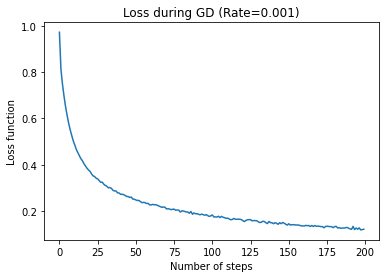

In [61]:
#check evolution of loss function
fig, ax = plt.subplots()
ax.plot(model.loss_curve_)
ax.set_title('Loss during GD (Rate=0.001)')
ax.set_ylabel('Loss function')
ax.set_xlabel('Number of steps')

Text(0.5, 0, 'Number of steps')

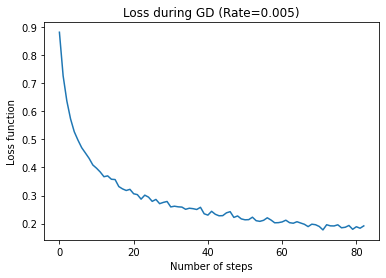

In [62]:
model.learning_rate_init=0.005
model.fit(X_train, y_train)
fig, ax = plt.subplots()
ax.plot(model.loss_curve_)
ax.set_title('Loss during GD (Rate=0.005)')
ax.set_ylabel('Loss function')
ax.set_xlabel('Number of steps')

Increasing the learning rate does not improve the situation.

In [65]:
#MLP does not converge with default values and increasing learning rate does not get us better results.
#try to do a quick grid search
mlp=MLPClassifier(random_state=39)
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1],
    'learning_rate_init': [10**-4, 10**-3, 10**-2, 10**-1],
}

In [66]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=39), n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(50,), (100,)],
                         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [67]:
# Best parametee set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}


              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3421
           1       0.92      0.96      0.94      4828
           2       0.96      0.96      0.96       240
           3       0.85      0.85      0.85       941
           4       0.90      0.82      0.86        66

    accuracy                           0.93      9496
   macro avg       0.92      0.90      0.91      9496
weighted avg       0.93      0.93      0.93      9496



Text(0.5, 15.0, 'Predicted')

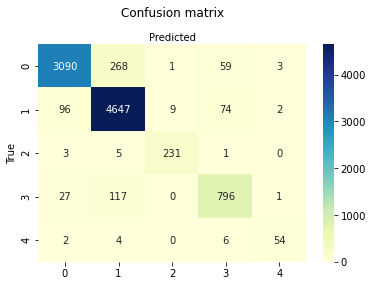

In [68]:
y_pred = pd.Series(clf.predict(X_test))
y_test = pd.Series(y_test)
print(metrics.classification_report(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

# 6. Classifying behavior from behavioral data

Here we attemp to predict behavior from joint angles.

### A. Wavelet Transfrom
The wavelet transform is used to add dynamic information to the data. This adds features according to the frequency of the signals.

In [ ]:
# Perform wavelet transform on all joint angles
angles = filtered_beh_df.filter(regex="angle")
manual_labels = filtered_beh_df.filter(regex="Manual")

# Standardize the data using the function from section 3A
angles_norm = standardize(angles)

nb_freqs = 25

freqs, power, beh_wave = wavelet_transform(np.array(angles_norm), n_freqs=nb_freqs, fsample=100., fmin=1., fmax=50.)


Here we plot the frequency components returned by wavelet transform, for time samples with walking and resting. The x-axis is a mixture of samples and does not have a continuous time meaning

In [ ]:
# Plot frequency components returned by wavelet transform, split into resting and walking

# for first 6 angles (front right leg)
for i in np.arange(6):
    
    # for two behavior types (resting, walking)
    for j in np.arange(2):
        fig, ax = plt.subplots(figsize = (5,5))
        start_id = i*nb_freqs
        select_indices = np.where(manual_labels == behaviors[j])[0]        
        
        im = plt.imshow(beh_wave.T[start_id:start_id+nb_freqs,select_indices[0:1000]], aspect=20, \
                        extent=[0,1000,50,1])
        plt.title(joints[i] + ', '+ behaviors[j])
        plt.xlabel('Samples')
        plt.ylabel('Frequency [Hz]')
        cbar = fig.colorbar(im, shrink=0.75)
        cbar.minorticks_on()
        
        fig.savefig('report_images/wavelet_' + joints[i] + '_'+ behaviors[j]+'.png')
        

### B. PCA on augmented data
We plot the augmented joint angles projected onto the first two PCA components

In [ ]:
# plot 2 dimensional data, with color for each behavioral label
def plot_2D_beh_labels(data, manual_labels, labels_list, xlabel, ylabel):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))

    for i in np.arange(len(labels_list)):
        select_indices = np.where(manual_labels == labels_list[i])
        plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.2)  
    
    plt.title('PCA projected joint angles')
    ax.set_xlabel(xlabel)

    ax.set_ylabel(ylabel)

    ax.legend(labels_list)
    fig.savefig('report_images/wavelet_pca.png')

In [ ]:
# PCA on augmented data
pca_angles = PCA(n_components=5)
beh_new = pca_angles.fit_transform(beh_wave)
print(pca_angles.explained_variance_ratio_)

plot_2D_beh_labels(beh_new[:,0:2], manual_labels, behaviors, \
                    'PCA component 1 ({:.2f}%)'.format(100*pca_angles.explained_variance_ratio_[0]),\
                    'PCA component 2 ({:.2f}%)'.format(100*pca_angles.explained_variance_ratio_[1]))